In [3]:
pip freeze

absl-py==2.1.0
adal==1.2.7
aiodns==3.2.0
aiohttp @ file:///C:/ci/aiohttp_1646806572557/work
aiohttp-socks==0.8.4
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
alembic==1.13.1
anaconda-client @ file:///C:/ci/anaconda-client_1635342725944/work
anaconda-navigator==2.1.4
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1637161053845/work
anyio @ file:///C:/ci/anyio_1644481921011/work/dist
appdirs==1.4.4
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644551690056/work
arrow @ file:///opt/conda/conda-bld/arrow_1649166651673/work
astroid @ file:///C:/ci/astroid_1628063282661/work
astropy @ file:///C:/ci/astropy_1650634291321/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
astunparse==1.6.3
async-timeout @ file:///tmp/build/80754af9/async-timeout_1637851218186/work
atomicwrites==1.4

bitarray @ file:///C:/ci/bitarray_1648739663053/work
bkcharts==0.2
black==19.10b0
bleach @ file:///opt/conda/conda-bld/bleach_1641577558959/work
bokeh @ file:///C:/ci/bokeh_1638362966927/work
boto3 @ file:///opt/conda/conda-bld/boto3_1649078879353/work
botocore @ file:///opt/conda/conda-bld/botocore_1649076662316/work
Bottleneck @ file:///C:/ci/bottleneck_1648010904582/work
branca==0.7.2
brotlipy==0.7.0
cachetools @ file:///tmp/build/80754af9/cachetools_1619597386817/work
cchardet==2.1.7
certifi==2021.10.8
cffi @ file:///C:/ci_310/cffi_1642682485096/work
chardet @ file:///C:/ci/chardet_1607706937985/work
charset-normalizer @ file:///tmp/build/80754af9/charset-normalizer_1630003229654/work
click @ file:///C:/ci/click_1646038595831/work
cloudpickle @ file:///tmp/build/80754af9/cloudpickle_1632508026186/work
clyent==1.2.2
cmdstanpy==1.2.0
colorama @ file:///tmp/build/80754af9/colorama_1607707115595/work
colorcet @ file:///tmp/build/80754af9/colorcet_1611168489822/work
colorlog==6.8.2
comt

# Importação de bibliotecas

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import numpy as np
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
import torch
import torch.nn as nn

# Declaração de funções

In [46]:
# Esta classe define uma Rede Neural Recorrente LSTM 
#(Long Short-Term Memory), que é um tipo de rede neural usada principalmente para tarefas de séries temporais e sequências.
class LSTM(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, num_layers, dropout_rate=0.5):
        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.layer = num_layers
        
        self.lstm = nn.LSTM(self.in_dim, self.hid_dim, self.layer, dropout=dropout_rate, batch_first=True)
        
        self.fc = nn.Linear(self.hid_dim, self.out_dim)
        
    def forward(self, x):
        
        # initialize the hidden state
        h0 = torch.zeros(self.layer, x.size(0), self.hid_dim)
        c0 = torch.zeros(self.layer, x.size(0), self.hid_dim)
        
        # forward propagate
        out, (h_,c_) = self.lstm(x,(h0,c0))
        
        out = self.fc(out[:,-1,:])
        return out
#Esta função treina o modelo LSTM usando os dados fornecidos.
def train_model(model,
               criterion,
               optimizer,
               x_train,
               x_test,
               y_train,
               y_test,
               epochs=500):
    
    train_loss = np.zeros(epochs)
    test_loss = np.zeros(epochs)
    
    for epoch in range(epochs):
        
        # put default model grads to zero
        optimizer.zero_grad()
        
        # predict the output
        pred = model(x_train)
        
        # calculate the loss 
        error = criterion(pred,y_train)
        
        # backpropagate the error
        error.backward()
        
        # update the model parameters
        optimizer.step()
        
        # save the losses 
        train_loss[epoch] = error.item()
        
        # test loss 
        test_pred = model(x_test)
        test_error = criterion(y_test,test_pred)
        test_loss[epoch] = test_error.item()
        
        if (epoch+1) % 5 ==0:
           print('Epoch :{}    Train Loss :{}    Test Loss :{}'.format((epoch+1)/epochs, error.item(), test_error.item()))
            
    return train_loss, test_loss


# divide the data into train and test
def split_data(x,y, ratio):
    assert len(x)==len(y)
    N = len(x)
    train_x, test_x  = x[:int(N*ratio)], x[int(N*ratio):]
    train_y, test_y  = y[:int(N*ratio)], y[int(N*ratio):]
    return train_x,train_y, test_x, test_y

# divide the data into number of steps 
def create_data(data, seq_len):
    N = len(data)
    X = []
    Y = []
    for i in range(N-seq_len-1):
        x = data[i:i+seq_len]
        X.append(x)
        y = data[i+seq_len]
        Y.append(y)
        
    return X,Y


# Realiza o pré-processamento de dados em um DataFrame.
def df_tratamento_dados(df):
    df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
    df = df.sort_values(by='data')
    # Completando dados
    # Crie um novo DataFrame com um intervalo completo de datas
    data_inicio = df['data'].min()  # Data de início
    data_fim = df['data'].max()  
    datas_completas = pd.date_range(start=data_inicio, end=data_fim, freq='D')
    # Crie um novo DataFrame com o intervalo completo de datas
    df_completo = pd.DataFrame(datas_completas, columns=['data'])# Faça um merge com o dataframe original

    df = df_completo.merge(df, on='data', how='left')
    df = df.sort_values(by='data')

    
    df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
    df.index = pd.to_datetime(df['data'])
    # Interpolação linear
    df['valor'] = df['valor'].interpolate(method='linear')
    df['valor'] = df['valor'].fillna(method='bfill')
    df.sort_index(ascending=True, inplace=True)
    #df = df.asfreq('D')
    df.drop('data', axis=1, inplace=True)
    return df

def ler_csv(caminho_arquivo):
    return pd.read_csv(caminho_arquivo, sep=',',usecols=[0,1], decimal=',', header=0)

# Escalona os dados e divide em treinamento e teste
def escalonar(df,treino_df, entradas, scale):
    percentual = len(treino_df)/len(df)
    entradas = entradas
    # scale the data
    df = scale.fit_transform(df)
    x,y = create_data(df,entradas)
    x, y = np.asarray(x), np.asarray(y)
    x.reshape(-1,entradas).shape
    train_x,train_y, test_x, test_y = split_data(x,y,percentual)
    # convert the data from numpy to tensor
    train_x = torch.from_numpy(train_x.astype(np.float32))
    train_y = torch.from_numpy(train_y.astype(np.float32))
    test_x = torch.from_numpy(test_x.astype(np.float32))
    test_y = torch.from_numpy(test_y.astype(np.float32))
    return x,y,train_x,train_y,test_x,test_y

# Leitura e tratamento dos dados

In [47]:
treino = ler_csv('dados_tratados/treino.csv')
teste = ler_csv('dados_tratados/teste.csv')
previsao = ler_csv('dados_tratados/previsao.csv')

In [48]:
df = pd.concat([treino,teste])

In [49]:
treino = df_tratamento_dados(treino)
teste = df_tratamento_dados(teste)
previsao = df_tratamento_dados(previsao)
df = df_tratamento_dados(df)

In [50]:
percentual = len(treino)/len(df)
percentual

0.8002738654147105

In [51]:
data_treino = treino.index
data_teste = teste.index
data_previsao = previsao.index

# Escalonando dados

In [53]:
percentual = len(treino)/len(df)
percentual

0.8002738654147105

In [54]:
entradas = 10
scale = MinMaxScaler(feature_range=(0,1))
x,y,train_x,train_y,test_x,test_y = escalonar(df,treino, entradas, scale)

# Treinando o modelo e aplicando o Grid Search

In [55]:
from sklearn.model_selection import ParameterGrid
params_grid = {'num_layers':[2,5],
               'hid_size':[50,100],
              'lr': [0.01,0.02],
               'epochs':[400,600],
              'dropout_rate':[0.5,0.8]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

from sklearn.metrics import mean_squared_error, mean_absolute_error

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
start_time = time.time()
for p in grid:
    
    lstm = LSTM(in_dim = x.shape[-1],
                hid_dim = p['hid_size'],
                out_dim = x.shape[-1],
                num_layers = p['num_layers'], 
                dropout_rate= p['dropout_rate'])
    
    optimizer = torch.optim.Adam(lstm.parameters(), lr=p['lr'])
    
    loss_fun = nn.MSELoss()
    
    train_loss, test_loss = train_model(lstm,
               loss_fun,
               optimizer,
               train_x,
               test_x,
               train_y,
               test_y,
               epochs=p['epochs'])

    
    # testing the predction model on multiple time series
    last_x = train_x[-1].view(entradas)

    prediction_val = []

    while len(prediction_val)<len(test_y):
        prediction = lstm(last_x.view(1,entradas,1))
        prediction_val.append(prediction[0,0].item())


        ## replace the predicted value in last x
        last_x = torch.cat((last_x[1:],prediction[0]))

    # plot the result
    train_y_cp = scale.inverse_transform(train_y.detach().numpy())
    test_y_cp = scale.inverse_transform(test_y.detach().numpy())
    prediction_val = scale.inverse_transform(np.asarray(prediction_val).reshape(-1,1))

    y_true = test_y_cp
    y_pred = prediction_val

    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {RMSE}')

    MAE = mean_absolute_error(y_true, y_pred)
    print(f'MAE: {MAE}')

    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f'MAPE: {MAPE}%')
    
    print(f'parametros: {p}')
    
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction = y_pred
        best_parameters = p
    
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)

end_time = time.time()
print(f"Tempo total de execução: {end_time - start_time} segundos")
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])


Total Possible Models 32
Epoch :0.0125    Train Loss :0.03609566017985344    Test Loss :0.2337789684534073
Epoch :0.025    Train Loss :0.02372235618531704    Test Loss :0.027363106608390808
Epoch :0.0375    Train Loss :0.006401128135621548    Test Loss :0.09242372959852219
Epoch :0.05    Train Loss :0.0025898751337081194    Test Loss :0.0067662750370800495
Epoch :0.0625    Train Loss :0.005455408710986376    Test Loss :0.020782044157385826
Epoch :0.075    Train Loss :0.0020903281401842833    Test Loss :0.005536013748496771
Epoch :0.0875    Train Loss :0.0015111742541193962    Test Loss :0.005025507882237434
Epoch :0.1    Train Loss :0.002060650149360299    Test Loss :0.015073130838572979
Epoch :0.1125    Train Loss :0.0011044967686757445    Test Loss :0.004338608123362064
Epoch :0.125    Train Loss :0.0010699898703023791    Test Loss :0.004289866425096989
Epoch :0.1375    Train Loss :0.0010407197987660766    Test Loss :0.005262303631752729
Epoch :0.15    Train Loss :0.00086775387171655

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.050150543451309204    Test Loss :0.3224029242992401
Epoch :0.025    Train Loss :0.04448748379945755    Test Loss :0.15958575904369354
Epoch :0.0375    Train Loss :0.041576653718948364    Test Loss :0.25914257764816284
Epoch :0.05    Train Loss :0.03895684704184532    Test Loss :0.18855984508991241
Epoch :0.0625    Train Loss :0.01600640080869198    Test Loss :0.025889305397868156
Epoch :0.075    Train Loss :0.010574069805443287    Test Loss :0.04654614254832268
Epoch :0.0875    Train Loss :0.010849719867110252    Test Loss :0.052771300077438354
Epoch :0.1    Train Loss :0.008058320730924606    Test Loss :0.013630393892526627
Epoch :0.1125    Train Loss :0.005133682396262884    Test Loss :0.01899396814405918
Epoch :0.125    Train Loss :0.003082232316955924    Test Loss :0.015771690756082535
Epoch :0.1375    Train Loss :0.0023813913576304913    Test Loss :0.009839746169745922
Epoch :0.15    Train Loss :0.0020042485557496548    Test Loss :0.00709564099088311

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.04112120345234871    Test Loss :0.08123306930065155
Epoch :0.025    Train Loss :0.005291163921356201    Test Loss :0.01757633686065674
Epoch :0.0375    Train Loss :0.0030625085346400738    Test Loss :0.02475629188120365
Epoch :0.05    Train Loss :0.0016708479961380363    Test Loss :0.005119803827255964
Epoch :0.0625    Train Loss :0.001990370685234666    Test Loss :0.009948063641786575
Epoch :0.075    Train Loss :0.0012041712179780006    Test Loss :0.003722504945471883
Epoch :0.0875    Train Loss :0.0008257701992988586    Test Loss :0.004016704857349396
Epoch :0.1    Train Loss :0.00086224265396595    Test Loss :0.002576502040028572
Epoch :0.1125    Train Loss :0.0007994279148988426    Test Loss :0.003181623760610819
Epoch :0.125    Train Loss :0.0006345185684040189    Test Loss :0.002730518113821745
Epoch :0.1375    Train Loss :0.0006442872690968215    Test Loss :0.0025540932547301054
Epoch :0.15    Train Loss :0.000598849612288177    Test Loss :0.002609

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.04341968894004822    Test Loss :0.25209179520606995
Epoch :0.025    Train Loss :0.03175734356045723    Test Loss :0.19054029881954193
Epoch :0.0375    Train Loss :0.049848996102809906    Test Loss :0.25920191407203674
Epoch :0.05    Train Loss :0.018261395394802094    Test Loss :0.05649498850107193
Epoch :0.0625    Train Loss :0.012824133969843388    Test Loss :0.03903675079345703
Epoch :0.075    Train Loss :0.012070518918335438    Test Loss :0.058898355811834335
Epoch :0.0875    Train Loss :0.008736029267311096    Test Loss :0.01866312138736248
Epoch :0.1    Train Loss :0.005693277809768915    Test Loss :0.0318794883787632
Epoch :0.1125    Train Loss :0.00606307340785861    Test Loss :0.02087082713842392
Epoch :0.125    Train Loss :0.003012041561305523    Test Loss :0.015665333718061447
Epoch :0.1375    Train Loss :0.002551635494455695    Test Loss :0.00736002204939723
Epoch :0.15    Train Loss :0.0023018652573227882    Test Loss :0.010473063215613365
Ep

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.04069523513317108    Test Loss :0.22057867050170898
Epoch :0.025    Train Loss :0.016716577112674713    Test Loss :0.009562669321894646
Epoch :0.0375    Train Loss :0.010503236204385757    Test Loss :0.026698337867856026
Epoch :0.05    Train Loss :0.0043206606060266495    Test Loss :0.022291839122772217
Epoch :0.0625    Train Loss :0.006144125014543533    Test Loss :0.004155096597969532
Epoch :0.075    Train Loss :0.003246761392802    Test Loss :0.003768328810110688
Epoch :0.0875    Train Loss :0.0012782851699739695    Test Loss :0.005771128926426172
Epoch :0.1    Train Loss :0.0013007454108446836    Test Loss :0.004221568815410137
Epoch :0.1125    Train Loss :0.0009946065256372094    Test Loss :0.0033544667530804873
Epoch :0.125    Train Loss :0.0008368965936824679    Test Loss :0.002993994625285268
Epoch :0.1375    Train Loss :0.0007588319131173193    Test Loss :0.003438571235165
Epoch :0.15    Train Loss :0.0007367565995082259    Test Loss :0.002240358

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.05441901832818985    Test Loss :0.3084776699542999
Epoch :0.025    Train Loss :0.041565798223018646    Test Loss :0.17339177429676056
Epoch :0.0375    Train Loss :0.041039809584617615    Test Loss :0.24610474705696106
Epoch :0.05    Train Loss :0.03759598731994629    Test Loss :0.1699441373348236
Epoch :0.0625    Train Loss :0.04145117849111557    Test Loss :0.03877615928649902
Epoch :0.075    Train Loss :0.011689034290611744    Test Loss :0.03774172440171242
Epoch :0.0875    Train Loss :0.010060198605060577    Test Loss :0.06354006379842758
Epoch :0.1    Train Loss :0.005405026022344828    Test Loss :0.029613202437758446
Epoch :0.1125    Train Loss :0.004367287736386061    Test Loss :0.006210717372596264
Epoch :0.125    Train Loss :0.001944115268997848    Test Loss :0.006794765125960112
Epoch :0.1375    Train Loss :0.0024565975181758404    Test Loss :0.010940732434391975
Epoch :0.15    Train Loss :0.0016211472684517503    Test Loss :0.005258781835436821


C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.1131158396601677    Test Loss :0.31177544593811035
Epoch :0.025    Train Loss :0.8957935571670532    Test Loss :0.2680964767932892
Epoch :0.0375    Train Loss :0.040991708636283875    Test Loss :0.4782993793487549
Epoch :0.05    Train Loss :0.03931413218379021    Test Loss :0.17281657457351685
Epoch :0.0625    Train Loss :0.040942706167697906    Test Loss :0.10509294271469116
Epoch :0.075    Train Loss :0.034515175968408585    Test Loss :0.21465396881103516
Epoch :0.0875    Train Loss :0.022094601765275    Test Loss :0.08066607266664505
Epoch :0.1    Train Loss :0.011974858120083809    Test Loss :0.034132152795791626
Epoch :0.1125    Train Loss :0.004011654295027256    Test Loss :0.025525908917188644
Epoch :0.125    Train Loss :0.004745400045067072    Test Loss :0.007986986078321934
Epoch :0.1375    Train Loss :0.003618750488385558    Test Loss :0.01754387654364109
Epoch :0.15    Train Loss :0.0023392499424517155    Test Loss :0.012352030724287033
Epoch :

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.07833925634622574    Test Loss :3.180297374725342
Epoch :0.025    Train Loss :0.13037298619747162    Test Loss :0.1052226796746254
Epoch :0.0375    Train Loss :0.0442747101187706    Test Loss :0.20231598615646362
Epoch :0.05    Train Loss :0.0405411422252655    Test Loss :0.2488919347524643
Epoch :0.0625    Train Loss :0.04049225524067879    Test Loss :0.18989697098731995
Epoch :0.075    Train Loss :0.04054643586277962    Test Loss :0.24529334902763367
Epoch :0.0875    Train Loss :0.04059682413935661    Test Loss :0.1969740390777588
Epoch :0.1    Train Loss :0.04060044512152672    Test Loss :0.23745745420455933
Epoch :0.1125    Train Loss :0.04059993103146553    Test Loss :0.20321184396743774
Epoch :0.125    Train Loss :0.040603265166282654    Test Loss :0.2307220697402954
Epoch :0.1375    Train Loss :0.04057038947939873    Test Loss :0.2099047303199768
Epoch :0.15    Train Loss :0.040528204292058945    Test Loss :0.22302758693695068
Epoch :0.1625    Trai

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.03980329632759094    Test Loss :0.2954349219799042
Epoch :0.016666666666666666    Train Loss :0.03584594652056694    Test Loss :0.1802894026041031
Epoch :0.025    Train Loss :0.026132168248295784    Test Loss :0.04660642892122269
Epoch :0.03333333333333333    Train Loss :0.009474233724176884    Test Loss :0.045817017555236816
Epoch :0.041666666666666664    Train Loss :0.0025352926459163427    Test Loss :0.010563629679381847
Epoch :0.05    Train Loss :0.004886448848992586    Test Loss :0.020166411995887756
Epoch :0.058333333333333334    Train Loss :0.0016908919205889106    Test Loss :0.0056445603258907795
Epoch :0.06666666666666667    Train Loss :0.0017902656691148877    Test Loss :0.005179674830287695
Epoch :0.075    Train Loss :0.0016282823635265231    Test Loss :0.01336975209414959
Epoch :0.08333333333333333    Train Loss :0.0011221494060009718    Test Loss :0.004572511650621891
Epoch :0.09166666666666666    Train Loss :0.00117204163689166

Epoch :0.7333333333333333    Train Loss :0.00022747358889319003    Test Loss :0.0005745443049818277
Epoch :0.7416666666666667    Train Loss :0.00030015219817869365    Test Loss :0.0008000400266610086
Epoch :0.75    Train Loss :0.00036229475517757237    Test Loss :0.0008634250261820853
Epoch :0.7583333333333333    Train Loss :0.00034460326423868537    Test Loss :0.0009168384131044149
Epoch :0.7666666666666667    Train Loss :0.0003044312179554254    Test Loss :0.0006859115092083812
Epoch :0.775    Train Loss :0.0002484121359884739    Test Loss :0.0005748920375481248
Epoch :0.7833333333333333    Train Loss :0.0002356487384531647    Test Loss :0.0005616085836663842
Epoch :0.7916666666666666    Train Loss :0.00022836358402855694    Test Loss :0.0005590848159044981
Epoch :0.8    Train Loss :0.00021986744832247496    Test Loss :0.0005487375310622156
Epoch :0.8083333333333333    Train Loss :0.00022678020468447357    Test Loss :0.0005162358283996582
Epoch :0.8166666666666667    Train Loss :0.00

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.05850108340382576    Test Loss :0.3821878135204315
Epoch :0.016666666666666666    Train Loss :0.04165877029299736    Test Loss :0.19635461270809174
Epoch :0.025    Train Loss :0.041622694581747055    Test Loss :0.21138650178909302
Epoch :0.03333333333333333    Train Loss :0.041813142597675323    Test Loss :0.2520217001438141
Epoch :0.041666666666666664    Train Loss :0.04025563970208168    Test Loss :0.21738408505916595
Epoch :0.05    Train Loss :0.0377727709710598    Test Loss :0.1884729266166687
Epoch :0.058333333333333334    Train Loss :0.017423201352357864    Test Loss :0.10596510022878647
Epoch :0.06666666666666667    Train Loss :0.008125724270939827    Test Loss :0.008520069532096386
Epoch :0.075    Train Loss :0.004932762589305639    Test Loss :0.009265710599720478
Epoch :0.08333333333333333    Train Loss :0.0048841251991689205    Test Loss :0.014940041117370129
Epoch :0.09166666666666666    Train Loss :0.002862149616703391    Test Lo

Epoch :0.7416666666666667    Train Loss :0.00039195208228193223    Test Loss :0.0017890294548124075
Epoch :0.75    Train Loss :0.000372263602912426    Test Loss :0.001940265647135675
Epoch :0.7583333333333333    Train Loss :0.0003766269364859909    Test Loss :0.001874010544270277
Epoch :0.7666666666666667    Train Loss :0.0003642254159785807    Test Loss :0.0015988865634426475
Epoch :0.775    Train Loss :0.0003614841552916914    Test Loss :0.0015094017144292593
Epoch :0.7833333333333333    Train Loss :0.0004084896936547011    Test Loss :0.0021411229390650988
Epoch :0.7916666666666666    Train Loss :0.0003506955981720239    Test Loss :0.0017577960388734937
Epoch :0.8    Train Loss :0.00034673811751417816    Test Loss :0.0018537843134254217
Epoch :0.8083333333333333    Train Loss :0.00036410699249245226    Test Loss :0.0017830373253673315
Epoch :0.8166666666666667    Train Loss :0.0003453102253843099    Test Loss :0.0017105224542319775
Epoch :0.825    Train Loss :0.0003735767968464643   

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  31.0
Epoch :0.008333333333333333    Train Loss :0.051470622420310974    Test Loss :0.2781341075897217
Epoch :0.016666666666666666    Train Loss :0.03904242068529129    Test Loss :0.1377013623714447
Epoch :0.025    Train Loss :0.0114654041826725    Test Loss :0.010984825901687145
Epoch :0.03333333333333333    Train Loss :0.0027199143078178167    Test Loss :0.017558574676513672
Epoch :0.041666666666666664    Train Loss :0.0022291545756161213    Test Loss :0.01474975049495697
Epoch :0.05    Train Loss :0.0015499088913202286    Test Loss :0.015131507068872452
Epoch :0.058333333333333334    Train Loss :0.001293806592002511    Test Loss :0.0051908292807638645
Epoch :0.06666666666666667    Train Loss :0.0010854514548555017    Test Loss :0.0033824476413428783
Epoch :0.075    Train Loss :0.0009887408232316375    Test Loss :0.003110388992354274
Epoch :0.08333333333333333    Train Loss :0.0008145967149175704    Test Loss :0.0035803888458758593
Epoch :0.09166666666666666    Train Loss :0.0

Epoch :0.7333333333333333    Train Loss :0.00021240995556581765    Test Loss :0.0008377456106245518
Epoch :0.7416666666666667    Train Loss :0.0002109423658112064    Test Loss :0.0009034493123181164
Epoch :0.75    Train Loss :0.0002596072154119611    Test Loss :0.0009685057448223233
Epoch :0.7583333333333333    Train Loss :0.0014437983045354486    Test Loss :0.0027287111151963472
Epoch :0.7666666666666667    Train Loss :0.00035240536089986563    Test Loss :0.001431307289749384
Epoch :0.775    Train Loss :0.00030079076532274485    Test Loss :0.0018072971142828465
Epoch :0.7833333333333333    Train Loss :0.0003328107704874128    Test Loss :0.0010308908531442285
Epoch :0.7916666666666666    Train Loss :0.00033373330370523036    Test Loss :0.0010759198339655995
Epoch :0.8    Train Loss :0.00028163345996290445    Test Loss :0.0008776739123277366
Epoch :0.8083333333333333    Train Loss :0.00026999818510375917    Test Loss :0.0009134124265983701
Epoch :0.8166666666666667    Train Loss :0.0002

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.0553659126162529    Test Loss :0.27309727668762207
Epoch :0.016666666666666666    Train Loss :0.04145276919007301    Test Loss :0.21445496380329132
Epoch :0.025    Train Loss :0.04078422486782074    Test Loss :0.226797953248024
Epoch :0.03333333333333333    Train Loss :0.04069077596068382    Test Loss :0.21381203830242157
Epoch :0.041666666666666664    Train Loss :0.040482260286808014    Test Loss :0.2219158113002777
Epoch :0.05    Train Loss :0.04047305881977081    Test Loss :0.21697020530700684
Epoch :0.058333333333333334    Train Loss :0.040510986000299454    Test Loss :0.21906328201293945
Epoch :0.06666666666666667    Train Loss :0.040443699806928635    Test Loss :0.2188846319913864
Epoch :0.075    Train Loss :0.040443990379571915    Test Loss :0.21742552518844604
Epoch :0.08333333333333333    Train Loss :0.040462736040353775    Test Loss :0.21930788457393646
Epoch :0.09166666666666666    Train Loss :0.04047830402851105    Test Loss :0.2

Epoch :0.7666666666666667    Train Loss :0.040454428642988205    Test Loss :0.21828600764274597
Epoch :0.775    Train Loss :0.0404617078602314    Test Loss :0.21845954656600952
Epoch :0.7833333333333333    Train Loss :0.040461860597133636    Test Loss :0.21829482913017273
Epoch :0.7916666666666666    Train Loss :0.04045926779508591    Test Loss :0.2184678167104721
Epoch :0.8    Train Loss :0.04045507311820984    Test Loss :0.21846958994865417
Epoch :0.8083333333333333    Train Loss :0.04045864939689636    Test Loss :0.21836362779140472
Epoch :0.8166666666666667    Train Loss :0.040453244000673294    Test Loss :0.2183191329240799
Epoch :0.825    Train Loss :0.04045309126377106    Test Loss :0.21805153787136078
Epoch :0.8333333333333334    Train Loss :0.04045265540480614    Test Loss :0.21844494342803955
Epoch :0.8416666666666667    Train Loss :0.040330756455659866    Test Loss :0.21749573945999146
Epoch :0.85    Train Loss :0.040539443492889404    Test Loss :0.20626696944236755
Epoch :0

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  38.0
Epoch :0.008333333333333333    Train Loss :0.03322101756930351    Test Loss :0.085905522108078
Epoch :0.016666666666666666    Train Loss :0.03404286876320839    Test Loss :0.05466895550489426
Epoch :0.025    Train Loss :0.008285685442388058    Test Loss :0.004981459118425846
Epoch :0.03333333333333333    Train Loss :0.010554241016507149    Test Loss :0.074474036693573
Epoch :0.041666666666666664    Train Loss :0.00286459201015532    Test Loss :0.027266234159469604
Epoch :0.05    Train Loss :0.004170132335275412    Test Loss :0.013738480396568775
Epoch :0.058333333333333334    Train Loss :0.003729521529749036    Test Loss :0.005946167279034853
Epoch :0.06666666666666667    Train Loss :0.0018073609098792076    Test Loss :0.005143795628100634
Epoch :0.075    Train Loss :0.001523941638879478    Test Loss :0.003023087978363037
Epoch :0.08333333333333333    Train Loss :0.0011451896280050278    Test Loss :0.005584319122135639
Epoch :0.09166666666666666    Train Loss :0.0008079482

Epoch :0.7333333333333333    Train Loss :0.00024148603552021086    Test Loss :0.0006377653335221112
Epoch :0.7416666666666667    Train Loss :0.0002528556215111166    Test Loss :0.0007215581135824323
Epoch :0.75    Train Loss :0.00024515268160030246    Test Loss :0.0006150946719571948
Epoch :0.7583333333333333    Train Loss :0.0002449402818456292    Test Loss :0.0006274942425079644
Epoch :0.7666666666666667    Train Loss :0.00023512264306191355    Test Loss :0.0006474117399193347
Epoch :0.775    Train Loss :0.0002320941857760772    Test Loss :0.0006474507972598076
Epoch :0.7833333333333333    Train Loss :0.00022948677360545844    Test Loss :0.000586486014071852
Epoch :0.7916666666666666    Train Loss :0.00022986704425420612    Test Loss :0.0005522386054508388
Epoch :0.8    Train Loss :0.00022981056827120483    Test Loss :0.0005452043260447681
Epoch :0.8083333333333333    Train Loss :0.00022307244944386184    Test Loss :0.0005577080883085728
Epoch :0.8166666666666667    Train Loss :0.000

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.041699301451444626    Test Loss :0.277098685503006
Epoch :0.016666666666666666    Train Loss :0.04124212637543678    Test Loss :0.2150920182466507
Epoch :0.025    Train Loss :0.026303505524992943    Test Loss :0.02074299193918705
Epoch :0.03333333333333333    Train Loss :0.027759026736021042    Test Loss :0.13091592490673065
Epoch :0.041666666666666664    Train Loss :0.026196377351880074    Test Loss :0.12337710708379745
Epoch :0.05    Train Loss :0.010230832733213902    Test Loss :0.04113030806183815
Epoch :0.058333333333333334    Train Loss :0.006599977612495422    Test Loss :0.043699342757463455
Epoch :0.06666666666666667    Train Loss :0.005488239228725433    Test Loss :0.006284452509135008
Epoch :0.075    Train Loss :0.0027800677344202995    Test Loss :0.006983011029660702
Epoch :0.08333333333333333    Train Loss :0.0020766044035553932    Test Loss :0.010591644793748856
Epoch :0.09166666666666666    Train Loss :0.001896533416584134    T

Epoch :0.7333333333333333    Train Loss :0.0003878501302096993    Test Loss :0.002043979475274682
Epoch :0.7416666666666667    Train Loss :0.0003771440824493766    Test Loss :0.0019729984924197197
Epoch :0.75    Train Loss :0.0003288010193500668    Test Loss :0.001726121292449534
Epoch :0.7583333333333333    Train Loss :0.00031464846688322723    Test Loss :0.0018155908910557628
Epoch :0.7666666666666667    Train Loss :0.00035569132887758315    Test Loss :0.0016913545550778508
Epoch :0.775    Train Loss :0.0004114230687264353    Test Loss :0.002034674398601055
Epoch :0.7833333333333333    Train Loss :0.0005357409245334566    Test Loss :0.0021595556754618883
Epoch :0.7916666666666666    Train Loss :0.00036619571619667113    Test Loss :0.0017988053150475025
Epoch :0.8    Train Loss :0.00034895280259661376    Test Loss :0.0017366278916597366
Epoch :0.8083333333333333    Train Loss :0.00039636011933907866    Test Loss :0.001911704195663333
Epoch :0.8166666666666667    Train Loss :0.00038172

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


 44.0
Epoch :0.008333333333333333    Train Loss :0.13178391754627228    Test Loss :0.5047999024391174
Epoch :0.016666666666666666    Train Loss :0.0411512665450573    Test Loss :0.13137558102607727
Epoch :0.025    Train Loss :0.07011660933494568    Test Loss :0.1946842521429062
Epoch :0.03333333333333333    Train Loss :0.07939823716878891    Test Loss :0.43247392773628235
Epoch :0.041666666666666664    Train Loss :0.04651235416531563    Test Loss :0.2567085921764374
Epoch :0.05    Train Loss :0.034774329513311386    Test Loss :0.11488626897335052
Epoch :0.058333333333333334    Train Loss :0.02606109343469143    Test Loss :0.12565499544143677
Epoch :0.06666666666666667    Train Loss :0.01806720159947872    Test Loss :0.05351120978593826
Epoch :0.075    Train Loss :0.005221398081630468    Test Loss :0.010257025249302387
Epoch :0.08333333333333333    Train Loss :0.00351884588599205    Test Loss :0.009824453853070736
Epoch :0.09166666666666666    Train Loss :0.003553125075995922    Test Lo

Epoch :0.7416666666666667    Train Loss :0.0005348734557628632    Test Loss :0.0013930335408076644
Epoch :0.75    Train Loss :0.0005402229726314545    Test Loss :0.001323253964073956
Epoch :0.7583333333333333    Train Loss :0.0005206139176152647    Test Loss :0.0015208640834316611
Epoch :0.7666666666666667    Train Loss :0.0005271725822240114    Test Loss :0.001307755010202527
Epoch :0.775    Train Loss :0.0005343431839719415    Test Loss :0.0014490761095657945
Epoch :0.7833333333333333    Train Loss :0.0005454081692732871    Test Loss :0.0013233722420409322
Epoch :0.7916666666666666    Train Loss :0.0005315066664479673    Test Loss :0.0013672378845512867
Epoch :0.8    Train Loss :0.0005388090503402054    Test Loss :0.0013851475669071078
Epoch :0.8083333333333333    Train Loss :0.0005450238240882754    Test Loss :0.0012235434260219336
Epoch :0.8166666666666667    Train Loss :0.0005419702501967549    Test Loss :0.0013089528074488044
Epoch :0.825    Train Loss :0.0005292033310979605    T

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  47.0
Epoch :0.008333333333333333    Train Loss :0.07068443298339844    Test Loss :0.35256049036979675
Epoch :0.016666666666666666    Train Loss :0.04225414618849754    Test Loss :0.17701546847820282
Epoch :0.025    Train Loss :0.04066307097673416    Test Loss :0.16859403252601624
Epoch :0.03333333333333333    Train Loss :0.03720682114362717    Test Loss :0.16177967190742493
Epoch :0.041666666666666664    Train Loss :0.04032188653945923    Test Loss :0.22363640367984772
Epoch :0.05    Train Loss :0.04019802436232567    Test Loss :0.26424440741539
Epoch :0.058333333333333334    Train Loss :0.03986304625868797    Test Loss :0.15736684203147888
Epoch :0.06666666666666667    Train Loss :0.028533723205327988    Test Loss :0.11598388850688934
Epoch :0.075    Train Loss :0.03095152974128723    Test Loss :0.03281962126493454
Epoch :0.08333333333333333    Train Loss :0.00792598631232977    Test Loss :0.059401992708444595
Epoch :0.09166666666666666    Train Loss :0.006944803521037102    T

Epoch :0.7416666666666667    Train Loss :0.0003904961049556732    Test Loss :0.0018521469319239259
Epoch :0.75    Train Loss :0.00039926328463479877    Test Loss :0.001915554516017437
Epoch :0.7583333333333333    Train Loss :0.0004261855792719871    Test Loss :0.0019954226445406675
Epoch :0.7666666666666667    Train Loss :0.00039663727511651814    Test Loss :0.002108419081196189
Epoch :0.775    Train Loss :0.00037877875729463995    Test Loss :0.0018123723566532135
Epoch :0.7833333333333333    Train Loss :0.00041992278420366347    Test Loss :0.0019051956478506327
Epoch :0.7916666666666666    Train Loss :0.0004597623774316162    Test Loss :0.002027332317084074
Epoch :0.8    Train Loss :0.000780215603299439    Test Loss :0.002645523054525256
Epoch :0.8083333333333333    Train Loss :0.00044799892930313945    Test Loss :0.0020464430563151836
Epoch :0.8166666666666667    Train Loss :0.0004905675305053592    Test Loss :0.0020447196438908577
Epoch :0.825    Train Loss :0.0004153789777774364   

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.04304426163434982    Test Loss :0.30804505944252014
Epoch :0.025    Train Loss :0.03339626267552376    Test Loss :0.11215526610612869
Epoch :0.0375    Train Loss :0.02460586279630661    Test Loss :0.1343744844198227
Epoch :0.05    Train Loss :0.013360419310629368    Test Loss :0.04393405094742775
Epoch :0.0625    Train Loss :0.005381848197430372    Test Loss :0.022607972845435143
Epoch :0.075    Train Loss :0.005489117465913296    Test Loss :0.025993410497903824
Epoch :0.0875    Train Loss :0.0026527117006480694    Test Loss :0.007076157722622156
Epoch :0.1    Train Loss :0.002157624578103423    Test Loss :0.006719144061207771
Epoch :0.1125    Train Loss :0.002203290816396475    Test Loss :0.012649977579712868
Epoch :0.125    Train Loss :0.0016594035550951958    Test Loss :0.005400558467954397
Epoch :0.1375    Train Loss :0.0014270349638536572    Test Loss :0.005244587082415819
Epoch :0.15    Train Loss :0.0013773288810625672    Test Loss :0.0057050054892

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.04089425131678581    Test Loss :0.21553738415241241
Epoch :0.025    Train Loss :0.03830336406826973    Test Loss :0.17663566768169403
Epoch :0.0375    Train Loss :0.016281060874462128    Test Loss :0.025725465267896652
Epoch :0.05    Train Loss :0.009132938459515572    Test Loss :0.04774374142289162
Epoch :0.0625    Train Loss :0.005755515303462744    Test Loss :0.013774704188108444
Epoch :0.075    Train Loss :0.0038277767598628998    Test Loss :0.012781571596860886
Epoch :0.0875    Train Loss :0.0037491568364202976    Test Loss :0.020646261051297188
Epoch :0.1    Train Loss :0.0030342168174684048    Test Loss :0.011766421608626842
Epoch :0.1125    Train Loss :0.0027556277345865965    Test Loss :0.006967690773308277
Epoch :0.125    Train Loss :0.002361407969146967    Test Loss :0.007731851655989885
Epoch :0.1375    Train Loss :0.00207564071752131    Test Loss :0.007697897031903267
Epoch :0.15    Train Loss :0.0020268894731998444    Test Loss :0.0081989048

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.04088304191827774    Test Loss :0.1659567952156067
Epoch :0.025    Train Loss :0.03286959230899811    Test Loss :0.2012917697429657
Epoch :0.0375    Train Loss :0.005560572259128094    Test Loss :0.044014785438776016
Epoch :0.05    Train Loss :0.006094480864703655    Test Loss :0.03063286282122135
Epoch :0.0625    Train Loss :0.0024230077397078276    Test Loss :0.013163429684937
Epoch :0.075    Train Loss :0.0037551415152847767    Test Loss :0.016421565786004066
Epoch :0.0875    Train Loss :0.002258873078972101    Test Loss :0.011138501577079296
Epoch :0.1    Train Loss :0.001623945077881217    Test Loss :0.005384099204093218
Epoch :0.1125    Train Loss :0.0017095553921535611    Test Loss :0.010989117436110973
Epoch :0.125    Train Loss :0.0014388752169907093    Test Loss :0.004705647937953472
Epoch :0.1375    Train Loss :0.001288196537643671    Test Loss :0.004711475223302841
Epoch :0.15    Train Loss :0.0012200191849842668    Test Loss :0.00529859447851

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.050182946026325226    Test Loss :0.2034674733877182
Epoch :0.025    Train Loss :0.04329756647348404    Test Loss :0.19376234710216522
Epoch :0.0375    Train Loss :0.041207991540431976    Test Loss :0.23403041064739227
Epoch :0.05    Train Loss :0.04089495912194252    Test Loss :0.20643234252929688
Epoch :0.0625    Train Loss :0.04082106426358223    Test Loss :0.22840218245983124
Epoch :0.075    Train Loss :0.040511354804039    Test Loss :0.2106393426656723
Epoch :0.0875    Train Loss :0.040537796914577484    Test Loss :0.22439588606357574
Epoch :0.1    Train Loss :0.04045514017343521    Test Loss :0.21491585671901703
Epoch :0.1125    Train Loss :0.0404893197119236    Test Loss :0.2203672230243683
Epoch :0.125    Train Loss :0.04051835834980011    Test Loss :0.21725352108478546
Epoch :0.1375    Train Loss :0.040445830672979355    Test Loss :0.2188543826341629
Epoch :0.15    Train Loss :0.04053300619125366    Test Loss :0.21862123906612396
Epoch :0.1625    

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.042265549302101135    Test Loss :0.18902836740016937
Epoch :0.025    Train Loss :0.019914917647838593    Test Loss :0.05647759512066841
Epoch :0.0375    Train Loss :0.005653519183397293    Test Loss :0.012325446121394634
Epoch :0.05    Train Loss :0.006083248648792505    Test Loss :0.03449670225381851
Epoch :0.0625    Train Loss :0.004274125210940838    Test Loss :0.006441543810069561
Epoch :0.075    Train Loss :0.0022813924588263035    Test Loss :0.011294624768197536
Epoch :0.0875    Train Loss :0.0018549702363088727    Test Loss :0.005258639343082905
Epoch :0.1    Train Loss :0.0012390889460220933    Test Loss :0.006220568437129259
Epoch :0.1125    Train Loss :0.0010032088030129671    Test Loss :0.0037617655470967293
Epoch :0.125    Train Loss :0.001016398542560637    Test Loss :0.0036154158879071474
Epoch :0.1375    Train Loss :0.0008032057667151093    Test Loss :0.0032093438785523176
Epoch :0.15    Train Loss :0.0008651542593725026    Test Loss :0.002

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.04209526628255844    Test Loss :0.20381589233875275
Epoch :0.025    Train Loss :0.02243347279727459    Test Loss :0.03596312925219536
Epoch :0.0375    Train Loss :0.017227185890078545    Test Loss :0.040787458419799805
Epoch :0.05    Train Loss :0.011785531416535378    Test Loss :0.01550261490046978
Epoch :0.0625    Train Loss :0.007917973212897778    Test Loss :0.04399961605668068
Epoch :0.075    Train Loss :0.005552527029067278    Test Loss :0.017237545922398567
Epoch :0.0875    Train Loss :0.004335516132414341    Test Loss :0.029243595898151398
Epoch :0.1    Train Loss :0.0034617322962731123    Test Loss :0.006572555750608444
Epoch :0.1125    Train Loss :0.002122177742421627    Test Loss :0.005780504550784826
Epoch :0.125    Train Loss :0.0024948373902589083    Test Loss :0.007923581637442112
Epoch :0.1375    Train Loss :0.0018463677261024714    Test Loss :0.006769130937755108
Epoch :0.15    Train Loss :0.001795386546291411    Test Loss :0.005384256597

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.16980305314064026    Test Loss :0.5319293737411499
Epoch :0.025    Train Loss :0.05425114184617996    Test Loss :0.35983479022979736
Epoch :0.0375    Train Loss :0.03632574900984764    Test Loss :0.21153785288333893
Epoch :0.05    Train Loss :0.031246915459632874    Test Loss :0.09589868783950806
Epoch :0.0625    Train Loss :0.01509072259068489    Test Loss :0.059565819799900055
Epoch :0.075    Train Loss :0.006548861972987652    Test Loss :0.02056220918893814
Epoch :0.0875    Train Loss :0.004826498683542013    Test Loss :0.017078807577490807
Epoch :0.1    Train Loss :0.0021783581469208    Test Loss :0.006937940139323473
Epoch :0.1125    Train Loss :0.00216201925650239    Test Loss :0.004129487089812756
Epoch :0.125    Train Loss :0.001818447490222752    Test Loss :0.00438538147136569
Epoch :0.1375    Train Loss :0.0015575289726257324    Test Loss :0.007893679663538933
Epoch :0.15    Train Loss :0.0012965122004970908    Test Loss :0.003953887615352869
Ep

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.20273251831531525    Test Loss :2.7154805660247803
Epoch :0.025    Train Loss :0.04301157221198082    Test Loss :0.28197333216667175
Epoch :0.0375    Train Loss :0.04589135944843292    Test Loss :0.1706390529870987
Epoch :0.05    Train Loss :0.04165929555892944    Test Loss :0.19305439293384552
Epoch :0.0625    Train Loss :0.04126403108239174    Test Loss :0.24755415320396423
Epoch :0.075    Train Loss :0.04134455695748329    Test Loss :0.20931608974933624
Epoch :0.0875    Train Loss :0.04079756885766983    Test Loss :0.21372312307357788
Epoch :0.1    Train Loss :0.040650784969329834    Test Loss :0.22997765243053436
Epoch :0.1125    Train Loss :0.04067739471793175    Test Loss :0.20994974672794342
Epoch :0.125    Train Loss :0.040508370846509933    Test Loss :0.22262772917747498
Epoch :0.1375    Train Loss :0.040705278515815735    Test Loss :0.21834547817707062
Epoch :0.15    Train Loss :0.04054231196641922    Test Loss :0.21477316319942474
Epoch :0.1625

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.036567557603120804    Test Loss :0.27184993028640747
Epoch :0.016666666666666666    Train Loss :0.031075989827513695    Test Loss :0.10768205672502518
Epoch :0.025    Train Loss :0.018343713134527206    Test Loss :0.09099344164133072
Epoch :0.03333333333333333    Train Loss :0.008779001422226429    Test Loss :0.022467799484729767
Epoch :0.041666666666666664    Train Loss :0.006139152683317661    Test Loss :0.0133065739646554
Epoch :0.05    Train Loss :0.00541391596198082    Test Loss :0.027073422446846962
Epoch :0.058333333333333334    Train Loss :0.003167299088090658    Test Loss :0.00767857488244772
Epoch :0.06666666666666667    Train Loss :0.0017407818231731653    Test Loss :0.008255569264292717
Epoch :0.075    Train Loss :0.0018781975377351046    Test Loss :0.013208327814936638
Epoch :0.08333333333333333    Train Loss :0.0014946991577744484    Test Loss :0.004932294599711895
Epoch :0.09166666666666666    Train Loss :0.001492991577833891 

Epoch :0.7333333333333333    Train Loss :0.00034478501765988767    Test Loss :0.0010648955358192325
Epoch :0.7416666666666667    Train Loss :0.0003518340818118304    Test Loss :0.0010512167355045676
Epoch :0.75    Train Loss :0.00034033480915240943    Test Loss :0.0010139562655240297
Epoch :0.7583333333333333    Train Loss :0.000349710404407233    Test Loss :0.000981967314146459
Epoch :0.7666666666666667    Train Loss :0.0004189105238765478    Test Loss :0.0011938861571252346
Epoch :0.775    Train Loss :0.0004017177561763674    Test Loss :0.001537370146252215
Epoch :0.7833333333333333    Train Loss :0.00034906904329545796    Test Loss :0.0013858303427696228
Epoch :0.7916666666666666    Train Loss :0.00034211858292110264    Test Loss :0.0011668126098811626
Epoch :0.8    Train Loss :0.0003446179907768965    Test Loss :0.0013261662097647786
Epoch :0.8083333333333333    Train Loss :0.00034823588794097304    Test Loss :0.0011551531497389078
Epoch :0.8166666666666667    Train Loss :0.0003263

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.055998895317316055    Test Loss :0.4082409143447876
Epoch :0.016666666666666666    Train Loss :0.058864787220954895    Test Loss :0.2954719364643097
Epoch :0.025    Train Loss :0.043901026248931885    Test Loss :0.23984737694263458
Epoch :0.03333333333333333    Train Loss :0.042163703590631485    Test Loss :0.23812739551067352
Epoch :0.041666666666666664    Train Loss :0.041530001908540726    Test Loss :0.19685055315494537
Epoch :0.05    Train Loss :0.04054878279566765    Test Loss :0.22545377910137177
Epoch :0.058333333333333334    Train Loss :0.040553804486989975    Test Loss :0.22686439752578735
Epoch :0.06666666666666667    Train Loss :0.03847990557551384    Test Loss :0.19684076309204102
Epoch :0.075    Train Loss :0.02952764369547367    Test Loss :0.1362958550453186
Epoch :0.08333333333333333    Train Loss :0.014440574683248997    Test Loss :0.03647153824567795
Epoch :0.09166666666666666    Train Loss :0.011586659587919712    Test Loss

Epoch :0.7416666666666667    Train Loss :0.0007702001021243632    Test Loss :0.0036569039802998304
Epoch :0.75    Train Loss :0.0007727653719484806    Test Loss :0.0031677919905632734
Epoch :0.7583333333333333    Train Loss :0.0007649603066965938    Test Loss :0.003116447711363435
Epoch :0.7666666666666667    Train Loss :0.0008052561315707862    Test Loss :0.0032751562539488077
Epoch :0.775    Train Loss :0.0008725497755222023    Test Loss :0.003136943094432354
Epoch :0.7833333333333333    Train Loss :0.000834811944514513    Test Loss :0.0034664839040488005
Epoch :0.7916666666666666    Train Loss :0.0008196883136406541    Test Loss :0.003540489124134183
Epoch :0.8    Train Loss :0.0008133405353873968    Test Loss :0.0029527107253670692
Epoch :0.8083333333333333    Train Loss :0.0007222371059469879    Test Loss :0.0035713466349989176
Epoch :0.8166666666666667    Train Loss :0.0008380125509575009    Test Loss :0.0033330887090414762
Epoch :0.825    Train Loss :0.0007973681786097586    Tes

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  81.0
Epoch :0.008333333333333333    Train Loss :0.03943494334816933    Test Loss :0.18190516531467438
Epoch :0.016666666666666666    Train Loss :0.011845085769891739    Test Loss :0.09212761372327805
Epoch :0.025    Train Loss :0.01108265295624733    Test Loss :0.023550909012556076
Epoch :0.03333333333333333    Train Loss :0.0036405089776962996    Test Loss :0.009494183585047722
Epoch :0.041666666666666664    Train Loss :0.003606353187933564    Test Loss :0.01723267324268818
Epoch :0.05    Train Loss :0.003085152246057987    Test Loss :0.021590448915958405
Epoch :0.058333333333333334    Train Loss :0.002645900472998619    Test Loss :0.004837607964873314
Epoch :0.06666666666666667    Train Loss :0.0018772347830235958    Test Loss :0.011228570714592934
Epoch :0.075    Train Loss :0.0016835483256727457    Test Loss :0.006305730435997248
Epoch :0.08333333333333333    Train Loss :0.0014453877229243517    Test Loss :0.005886281840503216
Epoch :0.09166666666666666    Train Loss :0.001

Epoch :0.7333333333333333    Train Loss :0.0003149551630485803    Test Loss :0.0008075993973761797
Epoch :0.7416666666666667    Train Loss :0.00031125551322475076    Test Loss :0.0009034062968567014
Epoch :0.75    Train Loss :0.0003078531881328672    Test Loss :0.0008084036526270211
Epoch :0.7583333333333333    Train Loss :0.000302081840345636    Test Loss :0.0008031277102418244
Epoch :0.7666666666666667    Train Loss :0.0004749041981995106    Test Loss :0.002596519188955426
Epoch :0.775    Train Loss :0.00042824086267501116    Test Loss :0.0010994585463777184
Epoch :0.7833333333333333    Train Loss :0.00036534538958221674    Test Loss :0.0008945728768594563
Epoch :0.7916666666666666    Train Loss :0.0002959240518976003    Test Loss :0.0009033935493789613
Epoch :0.8    Train Loss :0.000308301649056375    Test Loss :0.0007917557959444821
Epoch :0.8083333333333333    Train Loss :0.00033281417563557625    Test Loss :0.000900633167475462
Epoch :0.8166666666666667    Train Loss :0.000326816

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.043853890150785446    Test Loss :0.28257524967193604
Epoch :0.016666666666666666    Train Loss :0.04137548431754112    Test Loss :0.20484581589698792
Epoch :0.025    Train Loss :0.03680649399757385    Test Loss :0.1784212589263916
Epoch :0.03333333333333333    Train Loss :0.014877083711326122    Test Loss :0.046777721494436264
Epoch :0.041666666666666664    Train Loss :0.011904940940439701    Test Loss :0.041076332330703735
Epoch :0.05    Train Loss :0.009027897380292416    Test Loss :0.05475754663348198
Epoch :0.058333333333333334    Train Loss :0.006410668138414621    Test Loss :0.016574647277593613
Epoch :0.06666666666666667    Train Loss :0.004986589774489403    Test Loss :0.012450984679162502
Epoch :0.075    Train Loss :0.003984782379120588    Test Loss :0.007755720522254705
Epoch :0.08333333333333333    Train Loss :0.0032859419006854296    Test Loss :0.01069464348256588
Epoch :0.09166666666666666    Train Loss :0.002675466937944293    

Epoch :0.7416666666666667    Train Loss :0.0005963850417174399    Test Loss :0.002841597655788064
Epoch :0.75    Train Loss :0.0005377153283916414    Test Loss :0.0025349457282572985
Epoch :0.7583333333333333    Train Loss :0.0005174918915145099    Test Loss :0.0025467367377132177
Epoch :0.7666666666666667    Train Loss :0.0005216367426328361    Test Loss :0.0025804664473980665
Epoch :0.775    Train Loss :0.002970918780192733    Test Loss :0.003465278074145317
Epoch :0.7833333333333333    Train Loss :0.0013926008250564337    Test Loss :0.00941195897758007
Epoch :0.7916666666666666    Train Loss :0.000848670897539705    Test Loss :0.004584732931107283
Epoch :0.8    Train Loss :0.000855614198371768    Test Loss :0.0026688326615840197
Epoch :0.8083333333333333    Train Loss :0.0009564885403960943    Test Loss :0.0026974908541888
Epoch :0.8166666666666667    Train Loss :0.0006936139543540776    Test Loss :0.003180021420121193
Epoch :0.825    Train Loss :0.0006174137815833092    Test Loss :

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.047568317502737045    Test Loss :0.23639117181301117
Epoch :0.016666666666666666    Train Loss :0.026570305228233337    Test Loss :0.1262911558151245
Epoch :0.025    Train Loss :0.009863326326012611    Test Loss :0.10715407878160477
Epoch :0.03333333333333333    Train Loss :0.012267448008060455    Test Loss :0.037639301270246506
Epoch :0.041666666666666664    Train Loss :0.007022895850241184    Test Loss :0.027556760236620903
Epoch :0.05    Train Loss :0.0034452099353075027    Test Loss :0.008495387621223927
Epoch :0.058333333333333334    Train Loss :0.00184407620690763    Test Loss :0.016423001885414124
Epoch :0.06666666666666667    Train Loss :0.002202190924435854    Test Loss :0.0066439369693398476
Epoch :0.075    Train Loss :0.0016395744169130921    Test Loss :0.005537339951843023
Epoch :0.08333333333333333    Train Loss :0.0013724049786105752    Test Loss :0.0064734346233308315
Epoch :0.09166666666666666    Train Loss :0.001190850278362

Epoch :0.7333333333333333    Train Loss :0.00029057380743324757    Test Loss :0.0009147245436906815
Epoch :0.7416666666666667    Train Loss :0.0002709610271267593    Test Loss :0.0008318840991705656
Epoch :0.75    Train Loss :0.0002806770207826048    Test Loss :0.0008219340234063566
Epoch :0.7583333333333333    Train Loss :0.00028047492378391325    Test Loss :0.000843594316393137
Epoch :0.7666666666666667    Train Loss :0.0004742855380754918    Test Loss :0.0009280722006224096
Epoch :0.775    Train Loss :0.0003472892858553678    Test Loss :0.00082063750596717
Epoch :0.7833333333333333    Train Loss :0.0002999332791659981    Test Loss :0.0007909173727966845
Epoch :0.7916666666666666    Train Loss :0.000253230711678043    Test Loss :0.0007413350394926965
Epoch :0.8    Train Loss :0.00027974109980277717    Test Loss :0.0008608879870735109
Epoch :0.8083333333333333    Train Loss :0.000254900602158159    Test Loss :0.0008155258256010711
Epoch :0.8166666666666667    Train Loss :0.00026452765

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.04277774691581726    Test Loss :0.04066425561904907
Epoch :0.016666666666666666    Train Loss :0.06397082656621933    Test Loss :0.3477150797843933
Epoch :0.025    Train Loss :0.0479404553771019    Test Loss :0.1699177473783493
Epoch :0.03333333333333333    Train Loss :0.04070001468062401    Test Loss :0.23934783041477203
Epoch :0.041666666666666664    Train Loss :0.01646597497165203    Test Loss :0.061115335673093796
Epoch :0.05    Train Loss :0.01141022052615881    Test Loss :0.008023333735764027
Epoch :0.058333333333333334    Train Loss :0.00593619653955102    Test Loss :0.014646709896624088
Epoch :0.06666666666666667    Train Loss :0.005290046334266663    Test Loss :0.030029594898223877
Epoch :0.075    Train Loss :0.0035549935419112444    Test Loss :0.008825195021927357
Epoch :0.08333333333333333    Train Loss :0.0032351829577237368    Test Loss :0.007017115596681833
Epoch :0.09166666666666666    Train Loss :0.002546492265537381    Test 

Epoch :0.7416666666666667    Train Loss :0.0004322013119235635    Test Loss :0.002173009095713496
Epoch :0.75    Train Loss :0.00045080904965288937    Test Loss :0.0020920501556247473
Epoch :0.7583333333333333    Train Loss :0.0005552662187255919    Test Loss :0.002850176068022847
Epoch :0.7666666666666667    Train Loss :0.00046406188630498946    Test Loss :0.002465711673721671
Epoch :0.775    Train Loss :0.00046025938354432583    Test Loss :0.00210491381585598
Epoch :0.7833333333333333    Train Loss :0.00043713892227970064    Test Loss :0.002422875026240945
Epoch :0.7916666666666666    Train Loss :0.00042554110405035317    Test Loss :0.002139280317351222
Epoch :0.8    Train Loss :0.000457442132756114    Test Loss :0.001998181687667966
Epoch :0.8083333333333333    Train Loss :0.0006362698040902615    Test Loss :0.003357337787747383
Epoch :0.8166666666666667    Train Loss :0.00044951995369046926    Test Loss :0.0024483695160597563
Epoch :0.825    Train Loss :0.0005121823633089662    Tes

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.140053853392601    Test Loss :0.5274045467376709
Epoch :0.016666666666666666    Train Loss :0.04309356212615967    Test Loss :0.33360719680786133
Epoch :0.025    Train Loss :0.02826204150915146    Test Loss :0.14587000012397766
Epoch :0.03333333333333333    Train Loss :0.015770360827445984    Test Loss :0.08871050179004669
Epoch :0.041666666666666664    Train Loss :0.009071649052202702    Test Loss :0.03848602995276451
Epoch :0.05    Train Loss :0.008984414860606194    Test Loss :0.025577569380402565
Epoch :0.058333333333333334    Train Loss :0.00674776267260313    Test Loss :0.03778543323278427
Epoch :0.06666666666666667    Train Loss :0.0044427551329135895    Test Loss :0.028158368542790413
Epoch :0.075    Train Loss :0.003029654733836651    Test Loss :0.011715841479599476
Epoch :0.08333333333333333    Train Loss :0.0027644860092550516    Test Loss :0.009111536666750908
Epoch :0.09166666666666666    Train Loss :0.0024402400013059378    Tes

Epoch :0.7416666666666667    Train Loss :0.00041294560651294887    Test Loss :0.001860140124335885
Epoch :0.75    Train Loss :0.0004130234301555902    Test Loss :0.0018878240371122956
Epoch :0.7583333333333333    Train Loss :0.0004154363996349275    Test Loss :0.001822229940444231
Epoch :0.7666666666666667    Train Loss :0.00041818656609393656    Test Loss :0.0018176862504333258
Epoch :0.775    Train Loss :0.00041750911623239517    Test Loss :0.0017517186934128404
Epoch :0.7833333333333333    Train Loss :0.000402179139200598    Test Loss :0.0017527771415188909
Epoch :0.7916666666666666    Train Loss :0.0003769045870285481    Test Loss :0.0017531168414279819
Epoch :0.8    Train Loss :0.0004081666993442923    Test Loss :0.001806999440304935
Epoch :0.8083333333333333    Train Loss :0.0004882989451289177    Test Loss :0.001933768973685801
Epoch :0.8166666666666667    Train Loss :0.0005983270239084959    Test Loss :0.0020531448535621166
Epoch :0.825    Train Loss :0.0005238518351688981    T

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.08110085874795914    Test Loss :0.46675366163253784
Epoch :0.016666666666666666    Train Loss :0.08612794429063797    Test Loss :0.3859691917896271
Epoch :0.025    Train Loss :0.055372122675180435    Test Loss :0.17605817317962646
Epoch :0.03333333333333333    Train Loss :0.047909658402204514    Test Loss :0.25964221358299255
Epoch :0.041666666666666664    Train Loss :0.04289769381284714    Test Loss :0.22561220824718475
Epoch :0.05    Train Loss :0.04111073538661003    Test Loss :0.20803958177566528
Epoch :0.058333333333333334    Train Loss :0.040007006376981735    Test Loss :0.2139662802219391
Epoch :0.06666666666666667    Train Loss :0.034263093024492264    Test Loss :0.1700143963098526
Epoch :0.075    Train Loss :0.017834847792983055    Test Loss :0.057320062071084976
Epoch :0.08333333333333333    Train Loss :0.011328323744237423    Test Loss :0.039716511964797974
Epoch :0.09166666666666666    Train Loss :0.00837654247879982    Test Loss

Epoch :0.7416666666666667    Train Loss :0.0011595995165407658    Test Loss :0.00812614057213068
Epoch :0.75    Train Loss :0.0010523179080337286    Test Loss :0.01046825386583805
Epoch :0.7583333333333333    Train Loss :0.002431797794997692    Test Loss :0.0037820746656507254
Epoch :0.7666666666666667    Train Loss :0.001138741266913712    Test Loss :0.0037446029018610716
Epoch :0.775    Train Loss :0.001184598309919238    Test Loss :0.008790233172476292
Epoch :0.7833333333333333    Train Loss :0.0011771139688789845    Test Loss :0.005796388722956181
Epoch :0.7916666666666666    Train Loss :0.001064220443367958    Test Loss :0.004658039193600416
Epoch :0.8    Train Loss :0.0010639012325555086    Test Loss :0.004019497893750668
Epoch :0.8083333333333333    Train Loss :0.0010010587284341455    Test Loss :0.005815504118800163
Epoch :0.8166666666666667    Train Loss :0.0009526495123282075    Test Loss :0.0071066757664084435
Epoch :0.825    Train Loss :0.0009590142290107906    Test Loss :0

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3225279933.py:82: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


# Treinando o modelo com os parâmetros selecionados prevendo para os dados de teste

In [56]:
df_3 = pd.concat([treino, teste, previsao])
df_treino3=pd.concat([treino, teste])
df_teste=pd.concat([previsao])

In [57]:
entradas=10
x,y,train_x,train_y,test_x,test_y = escalonar(df_3,df_treino3, entradas,scale)

In [58]:

   
lstm = LSTM(in_dim = x.shape[-1],
            hid_dim = best_parameters['hid_size'],
            out_dim = x.shape[-1],
            num_layers =best_parameters['num_layers'], 
            dropout_rate= best_parameters['dropout_rate'])

optimizer = torch.optim.Adam(lstm.parameters(), lr=best_parameters['lr'])

loss_fun = nn.MSELoss()

train_loss, test_loss = train_model(lstm,
           loss_fun,
           optimizer,
           train_x,
           test_x,
           train_y,
           test_y,
           epochs=best_parameters['epochs'])


# testing the predction model on multiple time series
last_x = train_x[-1].view(entradas)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = lstm(last_x.view(1,entradas,1))
    prediction_val.append(prediction[0,0].item())


    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))

# plot the result
train_y_cp = scale.inverse_transform(train_y.detach().numpy())
test_y_cp = scale.inverse_transform(test_y.detach().numpy())
prediction_val = scale.inverse_transform(np.asarray(prediction_val).reshape(-1,1))

y_true = test_y_cp
y_pred = prediction_val

RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {RMSE}')

MAE = mean_absolute_error(y_true, y_pred)
print(f'MAE: {MAE}')

MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {MAPE}%')

print(best_parameters)



Epoch :0.008333333333333333    Train Loss :0.06046665459871292    Test Loss :0.32052528858184814
Epoch :0.016666666666666666    Train Loss :0.04072355851531029    Test Loss :0.055380597710609436
Epoch :0.025    Train Loss :0.016649985685944557    Test Loss :0.026895958930253983
Epoch :0.03333333333333333    Train Loss :0.013650776818394661    Test Loss :0.018873585388064384
Epoch :0.041666666666666664    Train Loss :0.006007291376590729    Test Loss :0.026177402585744858
Epoch :0.05    Train Loss :0.0028589642606675625    Test Loss :0.004122170619666576
Epoch :0.058333333333333334    Train Loss :0.0035995393991470337    Test Loss :0.012801063247025013
Epoch :0.06666666666666667    Train Loss :0.002964847255498171    Test Loss :0.015974011272192
Epoch :0.075    Train Loss :0.0018881431315094233    Test Loss :0.007179036736488342
Epoch :0.08333333333333333    Train Loss :0.001712470082566142    Test Loss :0.01076112873852253
Epoch :0.09166666666666666    Train Loss :0.0017999932169914246

Epoch :0.7416666666666667    Train Loss :0.0006702456739731133    Test Loss :0.0012978025479242206
Epoch :0.75    Train Loss :0.0005782379885204136    Test Loss :0.000617472396697849
Epoch :0.7583333333333333    Train Loss :0.0005206386558711529    Test Loss :0.0007747237104922533
Epoch :0.7666666666666667    Train Loss :0.0004799655289389193    Test Loss :0.0007517911726608872
Epoch :0.775    Train Loss :0.000502035953104496    Test Loss :0.0010893793078139424
Epoch :0.7833333333333333    Train Loss :0.0004184497520327568    Test Loss :0.0007507663685828447
Epoch :0.7916666666666666    Train Loss :0.0004659223777707666    Test Loss :0.0007696348475292325
Epoch :0.8    Train Loss :0.00043606467079371214    Test Loss :0.0008242328185588121
Epoch :0.8083333333333333    Train Loss :0.0004923990345560014    Test Loss :0.0011530040064826608
Epoch :0.8166666666666667    Train Loss :0.0009321735706180334    Test Loss :0.0009695770568214357
Epoch :0.825    Train Loss :0.0005662647890858352    

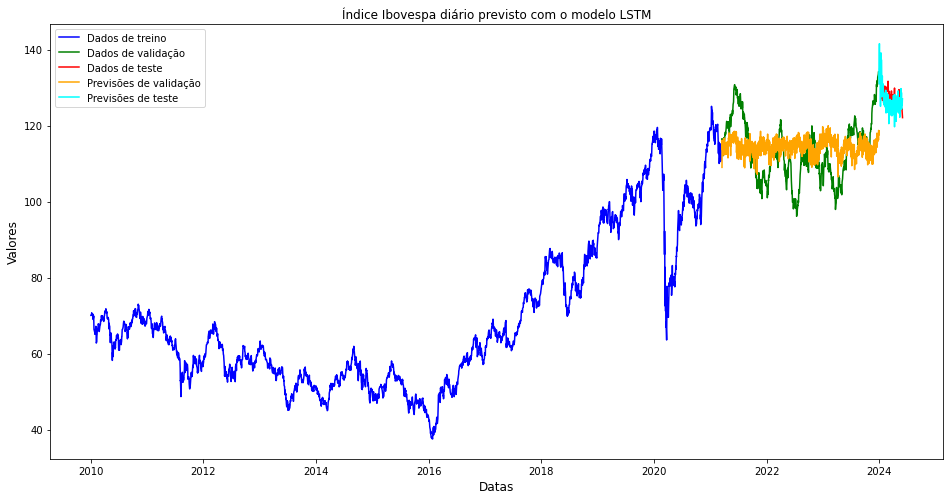

In [59]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(treino.index, treino['valor'],color='blue', label='Dados de treino')
plt.plot(teste.index, teste['valor'],color='green', label='Dados de validação')
plt.plot(previsao.index, previsao['valor'],color='red', label='Dados de teste')


# Linha das previsões
#plt.plot(prev_teste, label='Previsões testes', color='orange')
plt.plot(teste.index[2:],best_prediction,label='Previsões de validação',color = 'orange')
plt.plot(previsao.index,prediction_val,label='Previsões de teste',color = 'cyan')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo LSTM')

plt.legend()
plt.show()

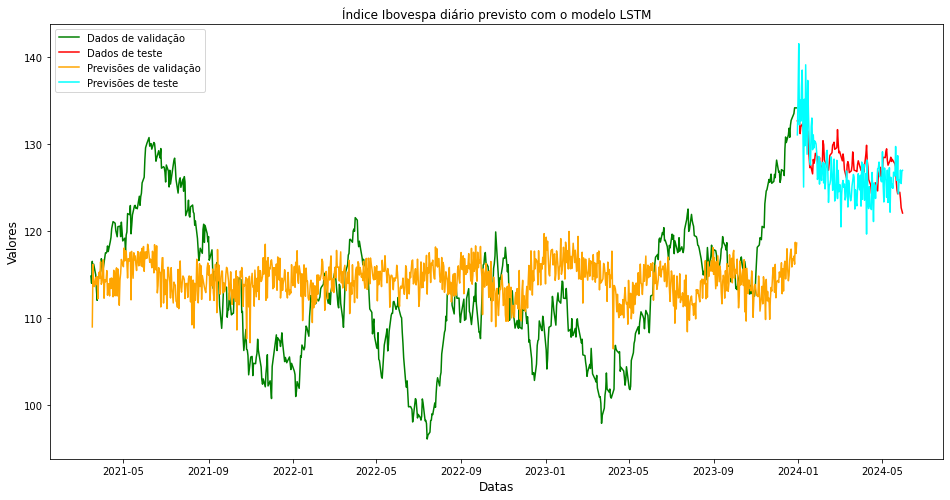

In [60]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
#plt.plot(treino.index, treino['valor'],color='blue', label='Dados de treino')
plt.plot(teste.index, teste['valor'],color='green', label='Dados de validação')
plt.plot(previsao.index, previsao['valor'],color='red', label='Dados de teste')


# Linha das previsões
#plt.plot(prev_teste, label='Previsões testes', color='orange')
plt.plot(teste.index[2:],best_prediction,label='Previsões de validação',color = 'orange')
plt.plot(previsao.index,prediction_val,label='Previsões de teste',color = 'cyan')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo LSTM')

plt.legend()
plt.show()

# Eliminando dados irregulares da pandemia

## Separando os dados 

In [61]:
treino1  = treino.loc['2016-01-01':'2020-02-01']
treino2 = treino.loc['2020-07-02':]
dados_pand = treino.loc['2020-02-02':'2020-07-01']

## Retirando os dados entre  02/02/2020 e 01/07/2020

In [62]:
# Defina o intervalo de datas
data_inicio = '2020-02-02'
data_fim = '2020-07-01'

# Crie as datas dentro do intervalo
datas = pd.date_range(start=data_inicio, end=data_fim, freq='D')

# Gere valores entre 110 e 120
valores = np.linspace(117.597180, 96.234960, num=len(datas))

# Crie um DataFrame com as datas e valores
dados_pand = pd.DataFrame({'data': datas, 'valor': valores})
dados_pand.index = dados_pand['data']
dados_pand.drop('data', axis=1, inplace=True)


In [63]:
treino_sem_pand = pd.concat([treino1,dados_pand,treino2])
df_2 = pd.concat([treino_sem_pand, teste])
df_treino=pd.concat([treino_sem_pand])

In [64]:
entradas=10
x,y,train_x,train_y,test_x,test_y = escalonar(df_2,df_treino, entradas,scale)

# Treinando o modelo e aplicando o Grid Search

In [65]:
from sklearn.model_selection import ParameterGrid
params_grid = {'num_layers':[2,5],
               'hid_size':[50,100],
              'lr': [0.01,0.02],
               'epochs':[400,600],
              'dropout_rate':[0.5,0.8]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

from sklearn.metrics import mean_squared_error, mean_absolute_error

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0
start_time = time.time()

for p in grid:
    
    lstm = LSTM(in_dim = x.shape[-1],
                hid_dim = p['hid_size'],
                out_dim = x.shape[-1],
                num_layers = p['num_layers'], 
                dropout_rate= p['dropout_rate'])
    
    optimizer = torch.optim.Adam(lstm.parameters(), lr=p['lr'])
    
    loss_fun = nn.MSELoss()
    
    train_loss, test_loss = train_model(lstm,
               loss_fun,
               optimizer,
               train_x,
               test_x,
               train_y,
               test_y,
               epochs=p['epochs'])

    
    # testing the predction model on multiple time series
    last_x = train_x[-1].view(entradas)

    prediction_val = []

    while len(prediction_val)<len(test_y):
        prediction = lstm(last_x.view(1,entradas,1))
        prediction_val.append(prediction[0,0].item())


        ## replace the predicted value in last x
        last_x = torch.cat((last_x[1:],prediction[0]))

    # plot the result
    train_y_cp = scale.inverse_transform(train_y.detach().numpy())
    test_y_cp = scale.inverse_transform(test_y.detach().numpy())
    prediction_val = scale.inverse_transform(np.asarray(prediction_val).reshape(-1,1))

    y_true = test_y_cp
    y_pred = prediction_val

    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {RMSE}')

    MAE = mean_absolute_error(y_true, y_pred)
    print(f'MAE: {MAE}')

    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f'MAPE: {MAPE}%')
    
    print(f'parametros: {p}')
    
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction = y_pred
        best_parameters = p
    
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)

end_time = time.time()
print(f"Tempo total de execução: {end_time - start_time} segundos")
parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

Total Possible Models 32
Epoch :0.0125    Train Loss :0.03594362363219261    Test Loss :0.17013584077358246
Epoch :0.025    Train Loss :0.039585042744874954    Test Loss :0.06001850590109825
Epoch :0.0375    Train Loss :0.030572840943932533    Test Loss :0.04794837161898613
Epoch :0.05    Train Loss :0.017648473381996155    Test Loss :0.014801830984652042
Epoch :0.0625    Train Loss :0.007553896401077509    Test Loss :0.014372364617884159
Epoch :0.075    Train Loss :0.0034046247601509094    Test Loss :0.004309099167585373
Epoch :0.0875    Train Loss :0.0025175302289426327    Test Loss :0.0037321592681109905
Epoch :0.1    Train Loss :0.0016446186928078532    Test Loss :0.006790869403630495
Epoch :0.1125    Train Loss :0.0020874750334769487    Test Loss :0.0035293796099722385
Epoch :0.125    Train Loss :0.0019039951730519533    Test Loss :0.005471232812851667
Epoch :0.1375    Train Loss :0.0012703875545412302    Test Loss :0.0026049937587231398
Epoch :0.15    Train Loss :0.00102737487759

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.05653408542275429    Test Loss :0.14689619839191437
Epoch :0.025    Train Loss :0.04934369772672653    Test Loss :0.1112370491027832
Epoch :0.0375    Train Loss :0.04814382642507553    Test Loss :0.08482695370912552
Epoch :0.05    Train Loss :0.03609111160039902    Test Loss :0.05020870640873909
Epoch :0.0625    Train Loss :0.016634901985526085    Test Loss :0.013800128363072872
Epoch :0.075    Train Loss :0.022326255217194557    Test Loss :0.05417338013648987
Epoch :0.0875    Train Loss :0.015226738527417183    Test Loss :0.008700833655893803
Epoch :0.1    Train Loss :0.012042134068906307    Test Loss :0.013300330378115177
Epoch :0.1125    Train Loss :0.006029200740158558    Test Loss :0.01272551529109478
Epoch :0.125    Train Loss :0.004168832208961248    Test Loss :0.0154656320810318
Epoch :0.1375    Train Loss :0.0032488962169736624    Test Loss :0.007783382665365934
Epoch :0.15    Train Loss :0.0023398189805448055    Test Loss :0.00539640337228775
Ep

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  6.0
Epoch :0.0125    Train Loss :0.04939766228199005    Test Loss :0.03763565793633461
Epoch :0.025    Train Loss :0.025614850223064423    Test Loss :0.014711039140820503
Epoch :0.0375    Train Loss :0.0030146553181111813    Test Loss :0.018456298857927322
Epoch :0.05    Train Loss :0.007387044373899698    Test Loss :0.008337889797985554
Epoch :0.0625    Train Loss :0.0020154668018221855    Test Loss :0.00368223013356328
Epoch :0.075    Train Loss :0.003395803039893508    Test Loss :0.009612425230443478
Epoch :0.0875    Train Loss :0.0015444260789081454    Test Loss :0.0037692950572818518
Epoch :0.1    Train Loss :0.0015339464880526066    Test Loss :0.002784941578283906
Epoch :0.1125    Train Loss :0.0013968133134767413    Test Loss :0.0026647266931831837
Epoch :0.125    Train Loss :0.0011176865082234144    Test Loss :0.0027703370433300734
Epoch :0.1375    Train Loss :0.000994852394796908    Test Loss :0.0024494777899235487
Epoch :0.15    Train Loss :0.000894848199095577    Tes

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.06721712648868561    Test Loss :0.1514224112033844
Epoch :0.025    Train Loss :0.05159275233745575    Test Loss :0.06836704909801483
Epoch :0.0375    Train Loss :0.04924120381474495    Test Loss :0.10098650306463242
Epoch :0.05    Train Loss :0.04250720143318176    Test Loss :0.0713830292224884
Epoch :0.0625    Train Loss :0.04927680641412735    Test Loss :0.046652235090732574
Epoch :0.075    Train Loss :0.03569352626800537    Test Loss :0.1059398427605629
Epoch :0.0875    Train Loss :0.013736261054873466    Test Loss :0.016429712995886803
Epoch :0.1    Train Loss :0.01647774875164032    Test Loss :0.022565575316548347
Epoch :0.1125    Train Loss :0.008424091152846813    Test Loss :0.011709615588188171
Epoch :0.125    Train Loss :0.007693012244999409    Test Loss :0.022413011640310287
Epoch :0.1375    Train Loss :0.005232406780123711    Test Loss :0.017316477373242378
Epoch :0.15    Train Loss :0.004205293022096157    Test Loss :0.0079776206985116
Epoch :

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.1424155980348587    Test Loss :0.470509797334671
Epoch :0.025    Train Loss :0.15531253814697266    Test Loss :0.3292600214481354
Epoch :0.0375    Train Loss :0.06420902907848358    Test Loss :0.07245272397994995
Epoch :0.05    Train Loss :0.06011597439646721    Test Loss :0.1715196967124939
Epoch :0.0625    Train Loss :0.03590736538171768    Test Loss :0.043361153453588486
Epoch :0.075    Train Loss :0.03345995396375656    Test Loss :0.04369102418422699
Epoch :0.0875    Train Loss :0.021401870995759964    Test Loss :0.024142589420080185
Epoch :0.1    Train Loss :0.008721728809177876    Test Loss :0.016666840761899948
Epoch :0.1125    Train Loss :0.004121651407331228    Test Loss :0.009327631443738937
Epoch :0.125    Train Loss :0.0037073262501507998    Test Loss :0.006967280991375446
Epoch :0.1375    Train Loss :0.002902667038142681    Test Loss :0.010443584993481636
Epoch :0.15    Train Loss :0.002120767254382372    Test Loss :0.005223790183663368
Epoch

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.12372037768363953    Test Loss :0.1517159640789032
Epoch :0.025    Train Loss :0.049852073192596436    Test Loss :0.05821804702281952
Epoch :0.0375    Train Loss :0.04864712059497833    Test Loss :0.12354275584220886
Epoch :0.05    Train Loss :0.03923654183745384    Test Loss :0.05507338419556618
Epoch :0.0625    Train Loss :0.017223505303263664    Test Loss :0.022168247029185295
Epoch :0.075    Train Loss :0.018680231645703316    Test Loss :0.03538692370057106
Epoch :0.0875    Train Loss :0.0058523258194327354    Test Loss :0.011247484013438225
Epoch :0.1    Train Loss :0.004510358441621065    Test Loss :0.004959689918905497
Epoch :0.1125    Train Loss :0.003211989300325513    Test Loss :0.006549111567437649
Epoch :0.125    Train Loss :0.0021902904845774174    Test Loss :0.004789083264768124
Epoch :0.1375    Train Loss :0.002001073444262147    Test Loss :0.004581365268677473
Epoch :0.15    Train Loss :0.0016835008282214403    Test Loss :0.003274087561294

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.17459547519683838    Test Loss :0.24424581229686737
Epoch :0.025    Train Loss :0.04586433246731758    Test Loss :0.10969323664903641
Epoch :0.0375    Train Loss :0.04539172351360321    Test Loss :0.08612086623907089
Epoch :0.05    Train Loss :0.03353150188922882    Test Loss :0.02311697043478489
Epoch :0.0625    Train Loss :0.01225163135677576    Test Loss :0.021860396489501
Epoch :0.075    Train Loss :0.004359534475952387    Test Loss :0.023817434906959534
Epoch :0.0875    Train Loss :0.004744797013700008    Test Loss :0.013647431507706642
Epoch :0.1    Train Loss :0.0031714916694909334    Test Loss :0.007669544778764248
Epoch :0.1125    Train Loss :0.0019941297359764576    Test Loss :0.006012970581650734
Epoch :0.125    Train Loss :0.0014442566316574812    Test Loss :0.0030472443904727697
Epoch :0.1375    Train Loss :0.0014385977992787957    Test Loss :0.0027645037043839693
Epoch :0.15    Train Loss :0.0010204082354903221    Test Loss :0.00247196480631

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.1527142971754074    Test Loss :1.7124836444854736
Epoch :0.025    Train Loss :0.11542455106973648    Test Loss :0.04922293499112129
Epoch :0.0375    Train Loss :0.058438289910554886    Test Loss :0.08668797463178635
Epoch :0.05    Train Loss :0.04871578887104988    Test Loss :0.14993877708911896
Epoch :0.0625    Train Loss :0.04896951839327812    Test Loss :0.06355055421590805
Epoch :0.075    Train Loss :0.04938620701432228    Test Loss :0.14158689975738525
Epoch :0.0875    Train Loss :0.04959569498896599    Test Loss :0.07207255065441132
Epoch :0.1    Train Loss :0.04976428300142288    Test Loss :0.12781189382076263
Epoch :0.1125    Train Loss :0.04956597462296486    Test Loss :0.08362838625907898
Epoch :0.125    Train Loss :0.04936891049146652    Test Loss :0.110979825258255
Epoch :0.1375    Train Loss :0.04884493350982666    Test Loss :0.09917423129081726
Epoch :0.15    Train Loss :0.04844564199447632    Test Loss :0.09651363641023636
Epoch :0.1625    

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.04826786369085312    Test Loss :0.16309690475463867
Epoch :0.016666666666666666    Train Loss :0.039234958589076996    Test Loss :0.058202773332595825
Epoch :0.025    Train Loss :0.023135269060730934    Test Loss :0.03798668086528778
Epoch :0.03333333333333333    Train Loss :0.009053915739059448    Test Loss :0.005892887711524963
Epoch :0.041666666666666664    Train Loss :0.004244833253324032    Test Loss :0.0048362212255597115
Epoch :0.05    Train Loss :0.0038917039055377245    Test Loss :0.0052529978565871716
Epoch :0.058333333333333334    Train Loss :0.0028757494874298573    Test Loss :0.0034505585208535194
Epoch :0.06666666666666667    Train Loss :0.0014873795444145799    Test Loss :0.004912617150694132
Epoch :0.075    Train Loss :0.0014757892349734902    Test Loss :0.0028794496320188046
Epoch :0.08333333333333333    Train Loss :0.0014465490821748972    Test Loss :0.0026541948318481445
Epoch :0.09166666666666666    Train Loss :0.00096194

Epoch :0.7333333333333333    Train Loss :0.0003857252304442227    Test Loss :0.0006261262460611761
Epoch :0.7416666666666667    Train Loss :0.0003593479632399976    Test Loss :0.0006454624817706645
Epoch :0.75    Train Loss :0.00034780066926032305    Test Loss :0.0005972718354314566
Epoch :0.7583333333333333    Train Loss :0.00033818191150203347    Test Loss :0.0007104174001142383
Epoch :0.7666666666666667    Train Loss :0.0003363713331054896    Test Loss :0.0005866987048648298
Epoch :0.775    Train Loss :0.00029842049116268754    Test Loss :0.0006040877779014409
Epoch :0.7833333333333333    Train Loss :0.0003072689287364483    Test Loss :0.0005645587807521224
Epoch :0.7916666666666666    Train Loss :0.00029163830913603306    Test Loss :0.000555345497559756
Epoch :0.8    Train Loss :0.00028582909726537764    Test Loss :0.0005360233481042087
Epoch :0.8083333333333333    Train Loss :0.0002705168444663286    Test Loss :0.0005063446005806327
Epoch :0.8166666666666667    Train Loss :0.00028

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.0753418356180191    Test Loss :0.2759815752506256
Epoch :0.016666666666666666    Train Loss :0.07134107500314713    Test Loss :0.17573794722557068
Epoch :0.025    Train Loss :0.05760788545012474    Test Loss :0.06179202347993851
Epoch :0.03333333333333333    Train Loss :0.04891331493854523    Test Loss :0.11997675895690918
Epoch :0.041666666666666664    Train Loss :0.04950212314724922    Test Loss :0.11599227786064148
Epoch :0.05    Train Loss :0.048437152057886124    Test Loss :0.09241537749767303
Epoch :0.058333333333333334    Train Loss :0.04844777658581734    Test Loss :0.09014486521482468
Epoch :0.06666666666666667    Train Loss :0.043757520616054535    Test Loss :0.08684570342302322
Epoch :0.075    Train Loss :0.0114854471758008    Test Loss :0.011283301748335361
Epoch :0.08333333333333333    Train Loss :0.012504404410719872    Test Loss :0.037175800651311874
Epoch :0.09166666666666666    Train Loss :0.01147629227489233    Test Loss :0

Epoch :0.7416666666666667    Train Loss :0.0005141181172803044    Test Loss :0.0015404458390548825
Epoch :0.75    Train Loss :0.0005031148320995271    Test Loss :0.001668046461418271
Epoch :0.7583333333333333    Train Loss :0.0004531509766820818    Test Loss :0.001629820093512535
Epoch :0.7666666666666667    Train Loss :0.0004709105414804071    Test Loss :0.0016399003798142076
Epoch :0.775    Train Loss :0.00045539397979155183    Test Loss :0.0014773898292332888
Epoch :0.7833333333333333    Train Loss :0.0004730080545414239    Test Loss :0.0014681839384138584
Epoch :0.7916666666666666    Train Loss :0.0004743205208797008    Test Loss :0.0014745399821549654
Epoch :0.8    Train Loss :0.00044478668132796884    Test Loss :0.0014958078972995281
Epoch :0.8083333333333333    Train Loss :0.0004419574688654393    Test Loss :0.0014632870443165302
Epoch :0.8166666666666667    Train Loss :0.0004420742334332317    Test Loss :0.0014602687442675233
Epoch :0.825    Train Loss :0.000432628090493381    

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.06927632540464401    Test Loss :0.1615508496761322
Epoch :0.016666666666666666    Train Loss :0.04372264817357063    Test Loss :0.06858190149068832
Epoch :0.025    Train Loss :0.015603571198880672    Test Loss :0.09551806002855301
Epoch :0.03333333333333333    Train Loss :0.03144856542348862    Test Loss :0.060765720903873444
Epoch :0.041666666666666664    Train Loss :0.018117601051926613    Test Loss :0.007001154590398073
Epoch :0.05    Train Loss :0.006079721264541149    Test Loss :0.02047611027956009
Epoch :0.058333333333333334    Train Loss :0.0024713375605642796    Test Loss :0.0038411812856793404
Epoch :0.06666666666666667    Train Loss :0.003867280902341008    Test Loss :0.0034499524626880884
Epoch :0.075    Train Loss :0.002468497958034277    Test Loss :0.0034729784820228815
Epoch :0.08333333333333333    Train Loss :0.0015684844693168998    Test Loss :0.0027583783958107233
Epoch :0.09166666666666666    Train Loss :0.00162862730212509

Epoch :0.7333333333333333    Train Loss :0.0003063191252294928    Test Loss :0.0005881398101337254
Epoch :0.7416666666666667    Train Loss :0.0002926346205640584    Test Loss :0.0005475063226185739
Epoch :0.75    Train Loss :0.0003020667645614594    Test Loss :0.000574711593799293
Epoch :0.7583333333333333    Train Loss :0.00028869646484963596    Test Loss :0.0005926846642978489
Epoch :0.7666666666666667    Train Loss :0.00029148635803721845    Test Loss :0.0005756705650128424
Epoch :0.775    Train Loss :0.0002935853262897581    Test Loss :0.0005758186453022063
Epoch :0.7833333333333333    Train Loss :0.00029399539926089346    Test Loss :0.0005894038476981223
Epoch :0.7916666666666666    Train Loss :0.0002806503907777369    Test Loss :0.0005240440368652344
Epoch :0.8    Train Loss :0.00029918653308413923    Test Loss :0.0005546245956793427
Epoch :0.8083333333333333    Train Loss :0.00040087883826345205    Test Loss :0.0010773532558232546
Epoch :0.8166666666666667    Train Loss :0.00071

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.12233076244592667    Test Loss :0.43549516797065735
Epoch :0.016666666666666666    Train Loss :0.09514053165912628    Test Loss :0.16178658604621887
Epoch :0.025    Train Loss :0.052263498306274414    Test Loss :0.1424800604581833
Epoch :0.03333333333333333    Train Loss :0.04996975511312485    Test Loss :0.10021162033081055
Epoch :0.041666666666666664    Train Loss :0.05009342357516289    Test Loss :0.0951334610581398
Epoch :0.05    Train Loss :0.04933986812829971    Test Loss :0.11809273064136505
Epoch :0.058333333333333334    Train Loss :0.048791006207466125    Test Loss :0.09221149981021881
Epoch :0.06666666666666667    Train Loss :0.04869537055492401    Test Loss :0.10028659552335739
Epoch :0.075    Train Loss :0.048874493688344955    Test Loss :0.10841525346040726
Epoch :0.08333333333333333    Train Loss :0.048753466457128525    Test Loss :0.0956716313958168
Epoch :0.09166666666666666    Train Loss :0.048607341945171356    Test Loss :0

Epoch :0.7666666666666667    Train Loss :0.04854963347315788    Test Loss :0.10104712098836899
Epoch :0.775    Train Loss :0.0484950914978981    Test Loss :0.10086585581302643
Epoch :0.7833333333333333    Train Loss :0.04856560006737709    Test Loss :0.1009913980960846
Epoch :0.7916666666666666    Train Loss :0.04852714762091637    Test Loss :0.10084337741136551
Epoch :0.8    Train Loss :0.04856051504611969    Test Loss :0.10111691057682037
Epoch :0.8083333333333333    Train Loss :0.04854441061615944    Test Loss :0.10100998729467392
Epoch :0.8166666666666667    Train Loss :0.04848146066069603    Test Loss :0.10091943293809891
Epoch :0.825    Train Loss :0.048484306782484055    Test Loss :0.10094580799341202
Epoch :0.8333333333333334    Train Loss :0.048488326370716095    Test Loss :0.10088355839252472
Epoch :0.8416666666666667    Train Loss :0.04850868135690689    Test Loss :0.10078172385692596
Epoch :0.85    Train Loss :0.048486851155757904    Test Loss :0.10102537274360657
Epoch :0.

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.1255561113357544    Test Loss :0.4261479675769806
Epoch :0.016666666666666666    Train Loss :0.15248478949069977    Test Loss :0.36487263441085815
Epoch :0.025    Train Loss :0.05843242257833481    Test Loss :0.014345401898026466
Epoch :0.03333333333333333    Train Loss :0.04604825749993324    Test Loss :0.14340396225452423
Epoch :0.041666666666666664    Train Loss :0.032545872032642365    Test Loss :0.04395163059234619
Epoch :0.05    Train Loss :0.01843174360692501    Test Loss :0.035461798310279846
Epoch :0.058333333333333334    Train Loss :0.00959861185401678    Test Loss :0.022626783698797226
Epoch :0.06666666666666667    Train Loss :0.005331296473741531    Test Loss :0.023750092834234238
Epoch :0.075    Train Loss :0.002819514600560069    Test Loss :0.0041191792115569115
Epoch :0.08333333333333333    Train Loss :0.0018690726719796658    Test Loss :0.006859881337732077
Epoch :0.09166666666666666    Train Loss :0.0013881660997867584    Te

Epoch :0.7333333333333333    Train Loss :0.00035143576678819954    Test Loss :0.0007030964479781687
Epoch :0.7416666666666667    Train Loss :0.00035851338179782033    Test Loss :0.0006789201288484037
Epoch :0.75    Train Loss :0.0003473816905170679    Test Loss :0.0006595978047698736
Epoch :0.7583333333333333    Train Loss :0.00034768422483466566    Test Loss :0.0006167232641018927
Epoch :0.7666666666666667    Train Loss :0.0003393458027858287    Test Loss :0.0006885419134050608
Epoch :0.775    Train Loss :0.0003474568366073072    Test Loss :0.0006084796623326838
Epoch :0.7833333333333333    Train Loss :0.0003319202223792672    Test Loss :0.000632879207842052
Epoch :0.7916666666666666    Train Loss :0.0003382029535714537    Test Loss :0.000613563577644527
Epoch :0.8    Train Loss :0.00033129469375126064    Test Loss :0.0006498302100226283
Epoch :0.8083333333333333    Train Loss :0.0003383425937499851    Test Loss :0.0006104406784288585
Epoch :0.8166666666666667    Train Loss :0.0004160

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.14938028156757355    Test Loss :0.48877930641174316
Epoch :0.016666666666666666    Train Loss :0.10545220226049423    Test Loss :0.10509846359491348
Epoch :0.025    Train Loss :0.06436758488416672    Test Loss :0.21595296263694763
Epoch :0.03333333333333333    Train Loss :0.05324991047382355    Test Loss :0.10452128946781158
Epoch :0.041666666666666664    Train Loss :0.051861535757780075    Test Loss :0.08902931958436966
Epoch :0.05    Train Loss :0.050831638276576996    Test Loss :0.13123352825641632
Epoch :0.058333333333333334    Train Loss :0.046028196811676025    Test Loss :0.08762248605489731
Epoch :0.06666666666666667    Train Loss :0.02625286392867565    Test Loss :0.024763718247413635
Epoch :0.075    Train Loss :0.01947993040084839    Test Loss :0.0815492570400238
Epoch :0.08333333333333333    Train Loss :0.010961201973259449    Test Loss :0.01600361056625843
Epoch :0.09166666666666666    Train Loss :0.009269936941564083    Test Loss

Epoch :0.7416666666666667    Train Loss :0.0005685915239155293    Test Loss :0.0019007098162546754
Epoch :0.75    Train Loss :0.0004828298115171492    Test Loss :0.0015349335735663772
Epoch :0.7583333333333333    Train Loss :0.0004535646876320243    Test Loss :0.001562940189614892
Epoch :0.7666666666666667    Train Loss :0.0004842269408982247    Test Loss :0.0013850340619683266
Epoch :0.775    Train Loss :0.00044406813685782254    Test Loss :0.0013208704767748713
Epoch :0.7833333333333333    Train Loss :0.0004673366784118116    Test Loss :0.0013354802504181862
Epoch :0.7916666666666666    Train Loss :0.00047198738320730627    Test Loss :0.0013670516200363636
Epoch :0.8    Train Loss :0.0004313152749091387    Test Loss :0.0013022110797464848
Epoch :0.8083333333333333    Train Loss :0.0003931335231754929    Test Loss :0.0013714416418224573
Epoch :0.8166666666666667    Train Loss :0.0004347130306996405    Test Loss :0.001284645521081984
Epoch :0.825    Train Loss :0.00044431176502257586  

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.1552944928407669    Test Loss :0.1136569008231163
Epoch :0.016666666666666666    Train Loss :0.15420472621917725    Test Loss :0.3383358120918274
Epoch :0.025    Train Loss :0.04695456847548485    Test Loss :0.06859320402145386
Epoch :0.03333333333333333    Train Loss :0.04919782280921936    Test Loss :0.08732616901397705
Epoch :0.041666666666666664    Train Loss :0.05069824680685997    Test Loss :0.13924269378185272
Epoch :0.05    Train Loss :0.045496463775634766    Test Loss :0.09393816441297531
Epoch :0.058333333333333334    Train Loss :0.04449237883090973    Test Loss :0.05986162647604942
Epoch :0.06666666666666667    Train Loss :0.03763900324702263    Test Loss :0.06049247086048126
Epoch :0.075    Train Loss :0.018449628725647926    Test Loss :0.018265925347805023
Epoch :0.08333333333333333    Train Loss :0.009575783275067806    Test Loss :0.00953667238354683
Epoch :0.09166666666666666    Train Loss :0.0058575887233018875    Test Loss :

Epoch :0.7333333333333333    Train Loss :0.0003369928163010627    Test Loss :0.0013187911827117205
Epoch :0.7416666666666667    Train Loss :0.0003774570650421083    Test Loss :0.0012017784174531698
Epoch :0.75    Train Loss :0.00046612878213636577    Test Loss :0.0012234391178935766
Epoch :0.7583333333333333    Train Loss :0.0004178682283964008    Test Loss :0.0012109715025871992
Epoch :0.7666666666666667    Train Loss :0.00032098242081701756    Test Loss :0.00122963753528893
Epoch :0.775    Train Loss :0.00033422381966374815    Test Loss :0.0012310919119045138
Epoch :0.7833333333333333    Train Loss :0.0003656285407487303    Test Loss :0.001338957459665835
Epoch :0.7916666666666666    Train Loss :0.0003224615065846592    Test Loss :0.001164324814453721
Epoch :0.8    Train Loss :0.0004778303555212915    Test Loss :0.0012382931308820844
Epoch :0.8083333333333333    Train Loss :0.0003372477658558637    Test Loss :0.0011796907056123018
Epoch :0.8166666666666667    Train Loss :0.0004835619

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.16560722887516022    Test Loss :1.8478879928588867
Epoch :0.016666666666666666    Train Loss :0.2082974910736084    Test Loss :0.014240533113479614
Epoch :0.025    Train Loss :0.10533575713634491    Test Loss :0.18509873747825623
Epoch :0.03333333333333333    Train Loss :0.07458935678005219    Test Loss :0.058036137372255325
Epoch :0.041666666666666664    Train Loss :0.06340685486793518    Test Loss :0.1435677707195282
Epoch :0.05    Train Loss :0.05727061629295349    Test Loss :0.07176879048347473
Epoch :0.058333333333333334    Train Loss :0.05394493415951729    Test Loss :0.1275380551815033
Epoch :0.06666666666666667    Train Loss :0.05163414403796196    Test Loss :0.0849420502781868
Epoch :0.075    Train Loss :0.05008493363857269    Test Loss :0.10955539345741272
Epoch :0.08333333333333333    Train Loss :0.04912411421537399    Test Loss :0.10002180188894272
Epoch :0.09166666666666666    Train Loss :0.04863967373967171    Test Loss :0.0957

Epoch :0.7666666666666667    Train Loss :0.04850402846932411    Test Loss :0.10091082751750946
Epoch :0.775    Train Loss :0.048503197729587555    Test Loss :0.1009168028831482
Epoch :0.7833333333333333    Train Loss :0.04850401356816292    Test Loss :0.10090291500091553
Epoch :0.7916666666666666    Train Loss :0.04850190877914429    Test Loss :0.10088477283716202
Epoch :0.8    Train Loss :0.04850428178906441    Test Loss :0.10090810060501099
Epoch :0.8083333333333333    Train Loss :0.048508819192647934    Test Loss :0.10090053826570511
Epoch :0.8166666666666667    Train Loss :0.04849807173013687    Test Loss :0.10090408474206924
Epoch :0.825    Train Loss :0.04849311709403992    Test Loss :0.10087898373603821
Epoch :0.8333333333333334    Train Loss :0.04850827902555466    Test Loss :0.10089239478111267
Epoch :0.8416666666666667    Train Loss :0.04850185662508011    Test Loss :0.10092388093471527
Epoch :0.85    Train Loss :0.04851037263870239    Test Loss :0.1009114682674408
Epoch :0.8

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.04601731896400452    Test Loss :0.1536559760570526
Epoch :0.025    Train Loss :0.038293205201625824    Test Loss :0.0355142205953598
Epoch :0.0375    Train Loss :0.024800149723887444    Test Loss :0.06003868579864502
Epoch :0.05    Train Loss :0.008731221780180931    Test Loss :0.013248136267066002
Epoch :0.0625    Train Loss :0.00486991461366415    Test Loss :0.015227721072733402
Epoch :0.075    Train Loss :0.004468778148293495    Test Loss :0.0061133848503232
Epoch :0.0875    Train Loss :0.0044194236397743225    Test Loss :0.004582616966217756
Epoch :0.1    Train Loss :0.0024145718198269606    Test Loss :0.009059268049895763
Epoch :0.1125    Train Loss :0.0022314705420285463    Test Loss :0.003364488249644637
Epoch :0.125    Train Loss :0.001909422455355525    Test Loss :0.0031331409700214863
Epoch :0.1375    Train Loss :0.001788390101864934    Test Loss :0.004661727696657181
Epoch :0.15    Train Loss :0.0014953708741813898    Test Loss :0.0028779332060

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.0674380213022232    Test Loss :0.2217082381248474
Epoch :0.025    Train Loss :0.04860149323940277    Test Loss :0.07744738459587097
Epoch :0.0375    Train Loss :0.049860432744026184    Test Loss :0.09466604143381119
Epoch :0.05    Train Loss :0.050502922385931015    Test Loss :0.13052792847156525
Epoch :0.0625    Train Loss :0.04654305800795555    Test Loss :0.0865623950958252
Epoch :0.075    Train Loss :0.02965172380208969    Test Loss :0.028999632224440575
Epoch :0.0875    Train Loss :0.02183893695473671    Test Loss :0.025227893143892288
Epoch :0.1    Train Loss :0.015122842974960804    Test Loss :0.04012278467416763
Epoch :0.1125    Train Loss :0.01389085128903389    Test Loss :0.014081625267863274
Epoch :0.125    Train Loss :0.010828389786183834    Test Loss :0.023557448759675026
Epoch :0.1375    Train Loss :0.008665092289447784    Test Loss :0.023900074884295464
Epoch :0.15    Train Loss :0.005692138336598873    Test Loss :0.009691823273897171
Epoch

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.17092397809028625    Test Loss :0.48365944623947144
Epoch :0.025    Train Loss :0.12805262207984924    Test Loss :0.2642625570297241
Epoch :0.0375    Train Loss :0.05403872951865196    Test Loss :0.08764565736055374
Epoch :0.05    Train Loss :0.05211874097585678    Test Loss :0.1437378227710724
Epoch :0.0625    Train Loss :0.03872719034552574    Test Loss :0.050753403455019
Epoch :0.075    Train Loss :0.027548475190997124    Test Loss :0.04462413489818573
Epoch :0.0875    Train Loss :0.011483014561235905    Test Loss :0.01978311687707901
Epoch :0.1    Train Loss :0.004879781510680914    Test Loss :0.018791163340210915
Epoch :0.1125    Train Loss :0.005261456128209829    Test Loss :0.01301205437630415
Epoch :0.125    Train Loss :0.0037112415302544832    Test Loss :0.006017136387526989
Epoch :0.1375    Train Loss :0.002705260878428817    Test Loss :0.0076441639102995396
Epoch :0.15    Train Loss :0.00209442968480289    Test Loss :0.004614644218236208
Epoch 

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.07241218537092209    Test Loss :0.14788289368152618
Epoch :0.025    Train Loss :0.049849577248096466    Test Loss :0.09150966256856918
Epoch :0.0375    Train Loss :0.047953516244888306    Test Loss :0.10913987457752228
Epoch :0.05    Train Loss :0.03151660040020943    Test Loss :0.022335601970553398
Epoch :0.0625    Train Loss :0.028270181268453598    Test Loss :0.023783810436725616
Epoch :0.075    Train Loss :0.017543859779834747    Test Loss :0.01958056539297104
Epoch :0.0875    Train Loss :0.009561721235513687    Test Loss :0.03376659005880356
Epoch :0.1    Train Loss :0.00825561210513115    Test Loss :0.010849975980818272
Epoch :0.1125    Train Loss :0.005379136651754379    Test Loss :0.013220088556408882
Epoch :0.125    Train Loss :0.00520820589736104    Test Loss :0.006595822982490063
Epoch :0.1375    Train Loss :0.004338182508945465    Test Loss :0.009172184392809868
Epoch :0.15    Train Loss :0.0035949680022895336    Test Loss :0.00492069404572248

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.14989231526851654    Test Loss :0.45281508564949036
Epoch :0.025    Train Loss :0.14036931097507477    Test Loss :0.32846879959106445
Epoch :0.0375    Train Loss :0.08759249001741409    Test Loss :0.03579305484890938
Epoch :0.05    Train Loss :0.05527899041771889    Test Loss :0.164643794298172
Epoch :0.0625    Train Loss :0.04053919017314911    Test Loss :0.07384902983903885
Epoch :0.075    Train Loss :0.03787066042423248    Test Loss :0.03274096921086311
Epoch :0.0875    Train Loss :0.023532360792160034    Test Loss :0.041709307581186295
Epoch :0.1    Train Loss :0.007512107491493225    Test Loss :0.017143987119197845
Epoch :0.1125    Train Loss :0.007761913817375898    Test Loss :0.011777881532907486
Epoch :0.125    Train Loss :0.004283644258975983    Test Loss :0.006147677078843117
Epoch :0.1375    Train Loss :0.0030845156870782375    Test Loss :0.008054418489336967
Epoch :0.15    Train Loss :0.0020157170947641134    Test Loss :0.004046742804348469
Ep

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.08215173333883286    Test Loss :0.07643218338489532
Epoch :0.025    Train Loss :0.04849761724472046    Test Loss :0.07093826681375504
Epoch :0.0375    Train Loss :0.025215571746230125    Test Loss :0.03228970244526863
Epoch :0.05    Train Loss :0.01642817258834839    Test Loss :0.05563979968428612
Epoch :0.0625    Train Loss :0.007670175284147263    Test Loss :0.009986823424696922
Epoch :0.075    Train Loss :0.007986962795257568    Test Loss :0.011119435541331768
Epoch :0.0875    Train Loss :0.004353209864348173    Test Loss :0.006300340872257948
Epoch :0.1    Train Loss :0.003348227823153138    Test Loss :0.004918980412185192
Epoch :0.1125    Train Loss :0.0027822835836559534    Test Loss :0.00911671295762062
Epoch :0.125    Train Loss :0.0021117969881743193    Test Loss :0.005301371216773987
Epoch :0.1375    Train Loss :0.002131787361577153    Test Loss :0.0034113889560103416
Epoch :0.15    Train Loss :0.0017235191771760583    Test Loss :0.0031279793474

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  69.0
Epoch :0.0125    Train Loss :0.174862802028656    Test Loss :0.1844761222600937
Epoch :0.025    Train Loss :0.07387198507785797    Test Loss :0.19435438513755798
Epoch :0.0375    Train Loss :0.04507119953632355    Test Loss :0.0352276973426342
Epoch :0.05    Train Loss :0.04227223992347717    Test Loss :0.09698396921157837
Epoch :0.0625    Train Loss :0.043260470032691956    Test Loss :0.10592690855264664
Epoch :0.075    Train Loss :0.03125673905014992    Test Loss :0.040254198014736176
Epoch :0.0875    Train Loss :0.006979446858167648    Test Loss :0.015358000993728638
Epoch :0.1    Train Loss :0.0035171937197446823    Test Loss :0.0068816859275102615
Epoch :0.1125    Train Loss :0.006082254461944103    Test Loss :0.013779167085886002
Epoch :0.125    Train Loss :0.0028739997651427984    Test Loss :0.0035184600856155157
Epoch :0.1375    Train Loss :0.0022364824544638395    Test Loss :0.004570946097373962
Epoch :0.15    Train Loss :0.002328727161511779    Test Loss :0.00363

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.603184163570404    Test Loss :0.3193516433238983
Epoch :0.025    Train Loss :0.11482303589582443    Test Loss :0.285066694021225
Epoch :0.0375    Train Loss :0.06540422886610031    Test Loss :0.1067681685090065
Epoch :0.05    Train Loss :0.04870007932186127    Test Loss :0.05982718616724014
Epoch :0.0625    Train Loss :0.04935754835605621    Test Loss :0.15998214483261108
Epoch :0.075    Train Loss :0.0509040467441082    Test Loss :0.0596320740878582
Epoch :0.0875    Train Loss :0.05176689475774765    Test Loss :0.1414584368467331
Epoch :0.1    Train Loss :0.05107851326465607    Test Loss :0.08069565892219543
Epoch :0.1125    Train Loss :0.04956886172294617    Test Loss :0.10564424842596054
Epoch :0.125    Train Loss :0.048576049506664276    Test Loss :0.10998446494340897
Epoch :0.1375    Train Loss :0.04860248044133186    Test Loss :0.08787993341684341
Epoch :0.15    Train Loss :0.04884720966219902    Test Loss :0.11002914607524872
Epoch :0.1625    Train

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  75.0
Epoch :0.008333333333333333    Train Loss :0.04640703275799751    Test Loss :0.13576067984104156
Epoch :0.016666666666666666    Train Loss :0.04423554986715317    Test Loss :0.08353651314973831
Epoch :0.025    Train Loss :0.03259241580963135    Test Loss :0.04125507175922394
Epoch :0.03333333333333333    Train Loss :0.006966351997107267    Test Loss :0.04447737708687782
Epoch :0.041666666666666664    Train Loss :0.00508143613114953    Test Loss :0.015328072011470795
Epoch :0.05    Train Loss :0.006579321343451738    Test Loss :0.016138583421707153
Epoch :0.058333333333333334    Train Loss :0.0030037355609238148    Test Loss :0.004599696956574917
Epoch :0.06666666666666667    Train Loss :0.0021572462283074856    Test Loss :0.004832705948501825
Epoch :0.075    Train Loss :0.0023514912463724613    Test Loss :0.007140966132283211
Epoch :0.08333333333333333    Train Loss :0.0021358123049139977    Test Loss :0.0035166728775948286
Epoch :0.09166666666666666    Train Loss :0.00143

Epoch :0.7333333333333333    Train Loss :0.000512738130055368    Test Loss :0.0008666710346005857
Epoch :0.7416666666666667    Train Loss :0.0004586205759551376    Test Loss :0.0009251867886632681
Epoch :0.75    Train Loss :0.00045993609819561243    Test Loss :0.0011007181601598859
Epoch :0.7583333333333333    Train Loss :0.0009958597365766764    Test Loss :0.0015951552195474505
Epoch :0.7666666666666667    Train Loss :0.0007526484550908208    Test Loss :0.0010521244257688522
Epoch :0.775    Train Loss :0.0004805230419151485    Test Loss :0.0012604621006175876
Epoch :0.7833333333333333    Train Loss :0.0005767088150605559    Test Loss :0.001024880213662982
Epoch :0.7916666666666666    Train Loss :0.000502477865666151    Test Loss :0.001009740517474711
Epoch :0.8    Train Loss :0.0004794937267433852    Test Loss :0.0011791227152571082
Epoch :0.8083333333333333    Train Loss :0.0004657742101699114    Test Loss :0.0008576102554798126
Epoch :0.8166666666666667    Train Loss :0.000433442008

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.07574199885129929    Test Loss :0.2833413779735565
Epoch :0.016666666666666666    Train Loss :0.08430658280849457    Test Loss :0.22096534073352814
Epoch :0.025    Train Loss :0.061919040977954865    Test Loss :0.076927550137043
Epoch :0.03333333333333333    Train Loss :0.04983999580144882    Test Loss :0.12064055353403091
Epoch :0.041666666666666664    Train Loss :0.04891517013311386    Test Loss :0.10480894148349762
Epoch :0.05    Train Loss :0.04891309142112732    Test Loss :0.08963260054588318
Epoch :0.058333333333333334    Train Loss :0.048654865473508835    Test Loss :0.09838194400072098
Epoch :0.06666666666666667    Train Loss :0.048798028379678726    Test Loss :0.10712752491235733
Epoch :0.075    Train Loss :0.048308394849300385    Test Loss :0.1008794978260994
Epoch :0.08333333333333333    Train Loss :0.04605705663561821    Test Loss :0.08541692793369293
Epoch :0.09166666666666666    Train Loss :0.031590692698955536    Test Loss :0.

Epoch :0.7416666666666667    Train Loss :0.0008463566191494465    Test Loss :0.0024592045228928328
Epoch :0.75    Train Loss :0.0007645972655154765    Test Loss :0.0026282237377017736
Epoch :0.7583333333333333    Train Loss :0.0007633130298927426    Test Loss :0.00258656800724566
Epoch :0.7666666666666667    Train Loss :0.0007304609171114862    Test Loss :0.002541676862165332
Epoch :0.775    Train Loss :0.0007368387887254357    Test Loss :0.0024200906045734882
Epoch :0.7833333333333333    Train Loss :0.0007314389804378152    Test Loss :0.0025761197321116924
Epoch :0.7916666666666666    Train Loss :0.0009546320070512593    Test Loss :0.0024942911695688963
Epoch :0.8    Train Loss :0.000981617602519691    Test Loss :0.002886744448915124
Epoch :0.8083333333333333    Train Loss :0.000840563967358321    Test Loss :0.0025241661351174116
Epoch :0.8166666666666667    Train Loss :0.0006894651451148093    Test Loss :0.002467628102749586
Epoch :0.825    Train Loss :0.0008125604945234954    Test L

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.14276552200317383    Test Loss :0.4769653379917145
Epoch :0.016666666666666666    Train Loss :0.10318977385759354    Test Loss :0.19177819788455963
Epoch :0.025    Train Loss :0.05337146669626236    Test Loss :0.08868054300546646
Epoch :0.03333333333333333    Train Loss :0.055109020322561264    Test Loss :0.16060957312583923
Epoch :0.041666666666666664    Train Loss :0.04266439005732536    Test Loss :0.07977831363677979
Epoch :0.05    Train Loss :0.04279918968677521    Test Loss :0.046107254922389984
Epoch :0.058333333333333334    Train Loss :0.030345486477017403    Test Loss :0.060478873550891876
Epoch :0.06666666666666667    Train Loss :0.016718678176403046    Test Loss :0.03666364774107933
Epoch :0.075    Train Loss :0.0096382275223732    Test Loss :0.01804291643202305
Epoch :0.08333333333333333    Train Loss :0.004856723360717297    Test Loss :0.012506362050771713
Epoch :0.09166666666666666    Train Loss :0.004094116855412722    Test Los

Epoch :0.7416666666666667    Train Loss :0.0008107290486805141    Test Loss :0.0019539070781320333
Epoch :0.75    Train Loss :0.0004806755168829113    Test Loss :0.0014591289218515158
Epoch :0.7583333333333333    Train Loss :0.000600548810325563    Test Loss :0.0015522497706115246
Epoch :0.7666666666666667    Train Loss :0.00047360596363432705    Test Loss :0.0010513912420719862
Epoch :0.775    Train Loss :0.0005272112903185189    Test Loss :0.0009696031920611858
Epoch :0.7833333333333333    Train Loss :0.0004558902292046696    Test Loss :0.0010691822972148657
Epoch :0.7916666666666666    Train Loss :0.0005027518491260707    Test Loss :0.0010746554471552372
Epoch :0.8    Train Loss :0.0004559361841529608    Test Loss :0.0009324203711003065
Epoch :0.8083333333333333    Train Loss :0.0005034825881011784    Test Loss :0.0009330863831564784
Epoch :0.8166666666666667    Train Loss :0.000490096805151552    Test Loss :0.0008860043017193675
Epoch :0.825    Train Loss :0.0004644008877221495    

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.0811508372426033    Test Loss :0.3554096817970276
Epoch :0.016666666666666666    Train Loss :0.07161151617765427    Test Loss :0.126125305891037
Epoch :0.025    Train Loss :0.0498194582760334    Test Loss :0.12949122488498688
Epoch :0.03333333333333333    Train Loss :0.050935205072164536    Test Loss :0.11556283384561539
Epoch :0.041666666666666664    Train Loss :0.050503943115472794    Test Loss :0.07648703455924988
Epoch :0.05    Train Loss :0.048134807497262955    Test Loss :0.1127125471830368
Epoch :0.058333333333333334    Train Loss :0.04177367687225342    Test Loss :0.0901157557964325
Epoch :0.06666666666666667    Train Loss :0.027155181393027306    Test Loss :0.04795576259493828
Epoch :0.075    Train Loss :0.017299484461545944    Test Loss :0.04647665098309517
Epoch :0.08333333333333333    Train Loss :0.014426338486373425    Test Loss :0.027545055374503136
Epoch :0.09166666666666666    Train Loss :0.011522308923304081    Test Loss :0.

Epoch :0.7416666666666667    Train Loss :0.0015324351843446493    Test Loss :0.004860890097916126
Epoch :0.75    Train Loss :0.0011091253254562616    Test Loss :0.004895210266113281
Epoch :0.7583333333333333    Train Loss :0.001051677973009646    Test Loss :0.003901472082361579
Epoch :0.7666666666666667    Train Loss :0.0010174816707149148    Test Loss :0.004933045245707035
Epoch :0.775    Train Loss :0.0009321208344772458    Test Loss :0.0039007230661809444
Epoch :0.7833333333333333    Train Loss :0.0009285208070650697    Test Loss :0.005654003471136093
Epoch :0.7916666666666666    Train Loss :0.0009508958319202065    Test Loss :0.003623205004259944
Epoch :0.8    Train Loss :0.0010014987783506513    Test Loss :0.004321782384067774
Epoch :0.8083333333333333    Train Loss :0.0009892627131193876    Test Loss :0.003986613359302282
Epoch :0.8166666666666667    Train Loss :0.000874156248755753    Test Loss :0.0038865217939019203
Epoch :0.825    Train Loss :0.0008691838011145592    Test Loss

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  88.0
Epoch :0.008333333333333333    Train Loss :0.11886792629957199    Test Loss :0.3139630854129791
Epoch :0.016666666666666666    Train Loss :0.045873161405324936    Test Loss :0.014814103953540325
Epoch :0.025    Train Loss :0.04086138308048248    Test Loss :0.10939578711986542
Epoch :0.03333333333333333    Train Loss :0.016970349475741386    Test Loss :0.023752879351377487
Epoch :0.041666666666666664    Train Loss :0.01985321193933487    Test Loss :0.010717128403484821
Epoch :0.05    Train Loss :0.004915380384773016    Test Loss :0.006430686917155981
Epoch :0.058333333333333334    Train Loss :0.004727572202682495    Test Loss :0.01183787640184164
Epoch :0.06666666666666667    Train Loss :0.004352397285401821    Test Loss :0.005171068944036961
Epoch :0.075    Train Loss :0.002336406148970127    Test Loss :0.0037937858141958714
Epoch :0.08333333333333333    Train Loss :0.0015900835860520601    Test Loss :0.005749205593019724
Epoch :0.09166666666666666    Train Loss :0.0018003

Epoch :0.7333333333333333    Train Loss :0.0004582199326250702    Test Loss :0.000798384309746325
Epoch :0.7416666666666667    Train Loss :0.00039652545819990337    Test Loss :0.0009033566457219422
Epoch :0.75    Train Loss :0.00038029049756005406    Test Loss :0.0008482391131110489
Epoch :0.7583333333333333    Train Loss :0.0004080423968844116    Test Loss :0.0009104142081923783
Epoch :0.7666666666666667    Train Loss :0.0004219259135425091    Test Loss :0.0010481628123670816
Epoch :0.775    Train Loss :0.00042528839549049735    Test Loss :0.0009552512783557177
Epoch :0.7833333333333333    Train Loss :0.00044651300413534045    Test Loss :0.000714364112354815
Epoch :0.7916666666666666    Train Loss :0.0003664778487291187    Test Loss :0.0007565769483335316
Epoch :0.8    Train Loss :0.0003751477343030274    Test Loss :0.0007274395320564508
Epoch :0.8083333333333333    Train Loss :0.0003512185940053314    Test Loss :0.0008276661392301321
Epoch :0.8166666666666667    Train Loss :0.0003850

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  91.0
Epoch :0.008333333333333333    Train Loss :0.15295188128948212    Test Loss :0.45265138149261475
Epoch :0.016666666666666666    Train Loss :0.11179084330797195    Test Loss :0.20791460573673248
Epoch :0.025    Train Loss :0.05313001200556755    Test Loss :0.14389246702194214
Epoch :0.03333333333333333    Train Loss :0.049586959183216095    Test Loss :0.08785835653543472
Epoch :0.041666666666666664    Train Loss :0.04957563802599907    Test Loss :0.10569317638874054
Epoch :0.05    Train Loss :0.04921447113156319    Test Loss :0.11346151679754257
Epoch :0.058333333333333334    Train Loss :0.049409907311201096    Test Loss :0.08673396706581116
Epoch :0.06666666666666667    Train Loss :0.048415590077638626    Test Loss :0.10906526446342468
Epoch :0.075    Train Loss :0.045429617166519165    Test Loss :0.08473353832960129
Epoch :0.08333333333333333    Train Loss :0.016790660098195076    Test Loss :0.014494058676064014
Epoch :0.09166666666666666    Train Loss :0.0161027442663908

Epoch :0.7416666666666667    Train Loss :0.0007583203841932118    Test Loss :0.002669393550604582
Epoch :0.75    Train Loss :0.0007682534051127732    Test Loss :0.0025002257898449898
Epoch :0.7583333333333333    Train Loss :0.0007555711199529469    Test Loss :0.0022709600161761045
Epoch :0.7666666666666667    Train Loss :0.0007838343735784292    Test Loss :0.002499964088201523
Epoch :0.775    Train Loss :0.0006943881162442267    Test Loss :0.0024589351378381252
Epoch :0.7833333333333333    Train Loss :0.0006996464799158275    Test Loss :0.0024475676473230124
Epoch :0.7916666666666666    Train Loss :0.0007403050549328327    Test Loss :0.0025871461257338524
Epoch :0.8    Train Loss :0.000700661854352802    Test Loss :0.0022288518957793713
Epoch :0.8083333333333333    Train Loss :0.0007276460528373718    Test Loss :0.0022671788465231657
Epoch :0.8166666666666667    Train Loss :0.0006936464924365282    Test Loss :0.0022469377145171165
Epoch :0.825    Train Loss :0.0006763184792362154    Te

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.12391818314790726    Test Loss :0.12781313061714172
Epoch :0.016666666666666666    Train Loss :0.03680628910660744    Test Loss :0.027639389038085938
Epoch :0.025    Train Loss :0.024409951642155647    Test Loss :0.06762296706438065
Epoch :0.03333333333333333    Train Loss :0.010049902833998203    Test Loss :0.04216510057449341
Epoch :0.041666666666666664    Train Loss :0.010889420285820961    Test Loss :0.017115170136094093
Epoch :0.05    Train Loss :0.007666415069252253    Test Loss :0.012671134434640408
Epoch :0.058333333333333334    Train Loss :0.005070023704320192    Test Loss :0.007342710625380278
Epoch :0.06666666666666667    Train Loss :0.0043258508667349815    Test Loss :0.007334110327064991
Epoch :0.075    Train Loss :0.0026700072921812534    Test Loss :0.006308337673544884
Epoch :0.08333333333333333    Train Loss :0.002587428782135248    Test Loss :0.004936125595122576
Epoch :0.09166666666666666    Train Loss :0.001946458010934293

Epoch :0.7333333333333333    Train Loss :0.0004109693691134453    Test Loss :0.0018712376477196813
Epoch :0.7416666666666667    Train Loss :0.00043355199159123003    Test Loss :0.001876693801023066
Epoch :0.75    Train Loss :0.00043499129242263734    Test Loss :0.0017918245866894722
Epoch :0.7583333333333333    Train Loss :0.0004267243202775717    Test Loss :0.001817032927647233
Epoch :0.7666666666666667    Train Loss :0.000422170152887702    Test Loss :0.001791540184058249
Epoch :0.775    Train Loss :0.0004066366236656904    Test Loss :0.0018142780754715204
Epoch :0.7833333333333333    Train Loss :0.0004181654949206859    Test Loss :0.0017362877260893583
Epoch :0.7916666666666666    Train Loss :0.0004196243826299906    Test Loss :0.0017704013735055923
Epoch :0.8    Train Loss :0.0004025092348456383    Test Loss :0.0018254331080242991
Epoch :0.8083333333333333    Train Loss :0.0004032233846373856    Test Loss :0.0017571391072124243
Epoch :0.8166666666666667    Train Loss :0.00039786400

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.1807914823293686    Test Loss :1.0145211219787598
Epoch :0.016666666666666666    Train Loss :0.049645617604255676    Test Loss :0.19267867505550385
Epoch :0.025    Train Loss :0.059740398079156876    Test Loss :0.05754954740405083
Epoch :0.03333333333333333    Train Loss :0.053043678402900696    Test Loss :0.10696156322956085
Epoch :0.041666666666666664    Train Loss :0.048693858087062836    Test Loss :0.12476587295532227
Epoch :0.05    Train Loss :0.04940761625766754    Test Loss :0.07444535940885544
Epoch :0.058333333333333334    Train Loss :0.05002640187740326    Test Loss :0.11842428892850876
Epoch :0.06666666666666667    Train Loss :0.04893321171402931    Test Loss :0.10289277136325836
Epoch :0.075    Train Loss :0.04858334735035896    Test Loss :0.08873768150806427
Epoch :0.08333333333333333    Train Loss :0.0488734170794487    Test Loss :0.10856740176677704
Epoch :0.09166666666666666    Train Loss :0.04855965077877045    Test Loss :0.

Epoch :0.7666666666666667    Train Loss :0.048524193465709686    Test Loss :0.10087786614894867
Epoch :0.775    Train Loss :0.0485069565474987    Test Loss :0.1008775383234024
Epoch :0.7833333333333333    Train Loss :0.04848957434296608    Test Loss :0.10077938437461853
Epoch :0.7916666666666666    Train Loss :0.04852207377552986    Test Loss :0.10091347992420197
Epoch :0.8    Train Loss :0.04851005971431732    Test Loss :0.10096586495637894
Epoch :0.8083333333333333    Train Loss :0.04851998761296272    Test Loss :0.10070157796144485
Epoch :0.8166666666666667    Train Loss :0.04851469025015831    Test Loss :0.1011430025100708
Epoch :0.825    Train Loss :0.0485125295817852    Test Loss :0.10073763132095337
Epoch :0.8333333333333334    Train Loss :0.04850153625011444    Test Loss :0.10105180740356445
Epoch :0.8416666666666667    Train Loss :0.04850633814930916    Test Loss :0.10081728547811508
Epoch :0.85    Train Loss :0.04851142317056656    Test Loss :0.10089506208896637
Epoch :0.8583

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\3723300266.py:83: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


In [73]:
print(parameters.loc[0, 'Parameters'])

{'dropout_rate': 0.5, 'epochs': 400, 'hid_size': 100, 'lr': 0.01, 'num_layers': 2}


In [74]:
parameters = model_parameters.sort_values(by=['MAE'])
parameters = parameters.reset_index(drop=True)
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

RMSE: 7.930554814887464
MAE: 6.432557521841557
MAPE: 5.564407815771348
{'dropout_rate': 0.5, 'epochs': 400, 'hid_size': 100, 'lr': 0.01, 'num_layers': 2}


In [75]:
best_parameters

{'dropout_rate': 0.5,
 'epochs': 400,
 'hid_size': 100,
 'lr': 0.01,
 'num_layers': 2}

In [76]:
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

RMSE: 7.930554814887464
MAE: 6.432557521841557
MAPE: 5.564407815771348
{'dropout_rate': 0.5, 'epochs': 400, 'hid_size': 100, 'lr': 0.01, 'num_layers': 2}


In [77]:
treino_sem_pand = pd.concat([treino1,dados_pand,treino2])
df_3 = pd.concat([treino_sem_pand, teste,previsao])
df_treino=pd.concat([treino_sem_pand, teste])
df_teste=pd.concat([previsao])

In [78]:
x,y,train_x,train_y,test_x,test_y = escalonar(df_3,df_treino, 10,scale)

In [79]:
   
lstm = LSTM(in_dim = x.shape[-1],
            hid_dim = best_parameters['hid_size'],
            out_dim = x.shape[-1],
            num_layers =best_parameters['num_layers'], 
            dropout_rate= best_parameters['dropout_rate'])

optimizer = torch.optim.Adam(lstm.parameters(), lr=best_parameters['lr'])

loss_fun = nn.MSELoss()

train_loss, test_loss = train_model(lstm,
           loss_fun,
           optimizer,
           train_x,
           test_x,
           train_y,
           test_y,
           epochs=best_parameters['epochs'])


# testing the predction model on multiple time series
last_x = train_x[-1].view(entradas)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = lstm(last_x.view(1,entradas,1))
    prediction_val.append(prediction[0,0].item())


    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))

# plot the result
train_y_cp = scale.inverse_transform(train_y.detach().numpy())
test_y_cp = scale.inverse_transform(test_y.detach().numpy())
prediction_val = scale.inverse_transform(np.asarray(prediction_val).reshape(-1,1))

y_true = test_y_cp
y_pred = prediction_val

RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {RMSE}')

MAE = mean_absolute_error(y_true, y_pred)
print(f'MAE: {MAE}')

MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {MAPE}%')

print(best_parameters)


Epoch :0.0125    Train Loss :0.20070041716098785    Test Loss :0.6603044271469116
Epoch :0.025    Train Loss :0.24863138794898987    Test Loss :0.5697527527809143
Epoch :0.0375    Train Loss :0.04676124081015587    Test Loss :0.004481671378016472
Epoch :0.05    Train Loss :0.052119310945272446    Test Loss :0.18505476415157318
Epoch :0.0625    Train Loss :0.058802224695682526    Test Loss :0.16619820892810822
Epoch :0.075    Train Loss :0.04228939861059189    Test Loss :0.04203690588474274
Epoch :0.0875    Train Loss :0.035472095012664795    Test Loss :0.06026223301887512
Epoch :0.1    Train Loss :0.025254011154174805    Test Loss :0.04066075384616852
Epoch :0.1125    Train Loss :0.004586698021739721    Test Loss :0.011479837819933891
Epoch :0.125    Train Loss :0.006622417829930782    Test Loss :0.0053498996421694756
Epoch :0.1375    Train Loss :0.003034240799024701    Test Loss :0.005886945873498917
Epoch :0.15    Train Loss :0.004072023555636406    Test Loss :0.021091721951961517
Ep

In [81]:
len(treino_sem_pand)

1900

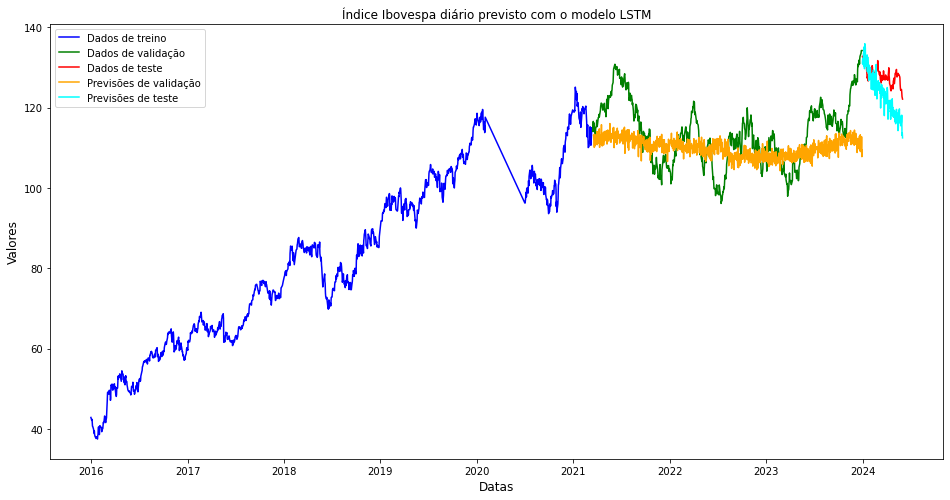

In [82]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(treino_sem_pand.index, treino_sem_pand['valor'],color='blue', label='Dados de treino')
plt.plot(teste.index, teste['valor'],color='green', label='Dados de validação')
plt.plot(previsao.index, previsao['valor'],color='red', label='Dados de teste')


# Linha das previsões
#plt.plot(prev_teste, label='Previsões testes', color='orange')
plt.plot(teste.index[3:],best_prediction,label='Previsões de validação',color = 'orange')
plt.plot(previsao.index,prediction_val,label='Previsões de teste',color = 'cyan')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo LSTM')

plt.legend()
plt.show()

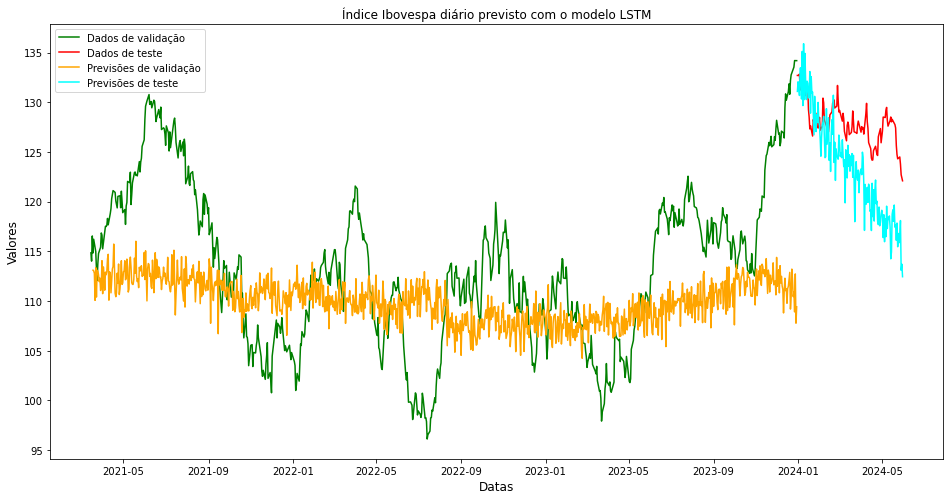

In [83]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
#plt.plot(treino_sem_pand.index, treino_sem_pand['valor'],color='blue', label='Dados de treino')
plt.plot(teste.index, teste['valor'],color='green', label='Dados de validação')
plt.plot(previsao.index, previsao['valor'],color='red', label='Dados de teste')


# Linha das previsões
#plt.plot(prev_teste, label='Previsões testes', color='orange')
plt.plot(teste.index[3:],best_prediction,label='Previsões de validação',color = 'orange')
plt.plot(previsao.index,prediction_val,label='Previsões de teste',color = 'cyan')

plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa diário previsto com o modelo LSTM')

plt.legend()
plt.show()

# Série com dados mensais

In [84]:
treino_mensal = treino.copy()
teste_mensal = teste.copy()
previsao_mensal = previsao.copy()

In [85]:
treino_mensal = treino_mensal['valor'].resample('M').mean()
teste_mensal = teste_mensal['valor'].resample('M').mean()
previsao_mensal = previsao_mensal['valor'].resample('M').mean()
data = treino_mensal.to_frame()

In [86]:
treino_mensal = treino_mensal.to_frame(name='valor')
teste_mensal = teste_mensal.to_frame(name='valor')
previsao_mensal = previsao_mensal.to_frame(name='valor')

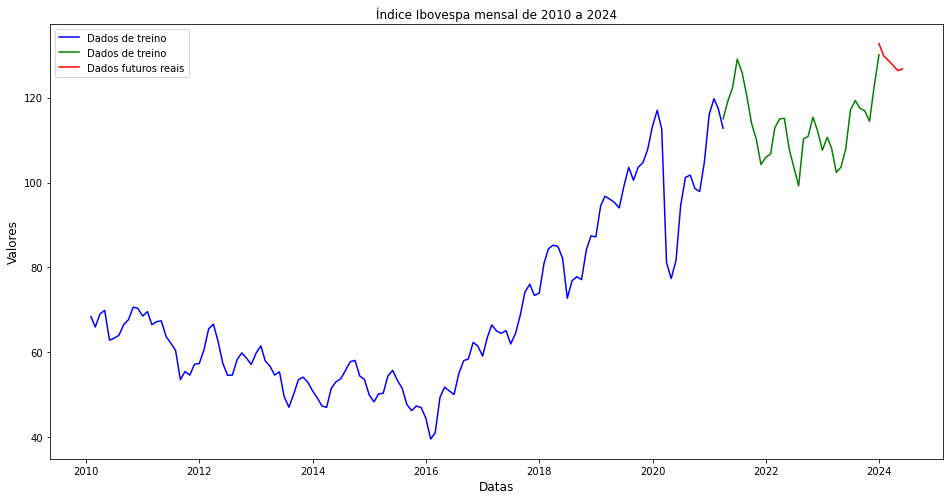

In [87]:


#suavizado = pd.concat([treino_mensal,teste_mensal, previsao_mensal])
##Monthly Stock Price 
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(treino_mensal,color='blue', label='Dados de treino')
plt.plot(teste_mensal,color='green', label='Dados de treino')
plt.plot(previsao_mensal,color='red', label='Dados futuros reais')



plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa mensal de 2010 a 2024')

plt.legend()
plt.show()

In [88]:
df_4 = pd.concat([treino_mensal, teste_mensal])
df_treino = treino_mensal
df_teste=pd.concat([teste_mensal])

In [89]:
entradas = 10
x,y,train_x,train_y,test_x,test_y = escalonar(df_4,df_treino, entradas,scale)

In [90]:
from sklearn.model_selection import ParameterGrid
params_grid = {'num_layers':[2,5],
               'hid_size':[50,100],
              'lr': [0.01,0.02],
               'epochs':[400,600],
              'dropout_rate':[0.5,0.8]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

from sklearn.metrics import mean_squared_error, mean_absolute_error

start_time = time.time()

model_parameters = pd.DataFrame(columns = ['RMSE','Parameters'])
best_rmse = np.inf
best_prediction=None
count = 0

for p in grid:
    
    lstm = LSTM(in_dim = x.shape[-1],
                hid_dim = p['hid_size'],
                out_dim = x.shape[-1],
                num_layers = p['num_layers'], 
                dropout_rate= p['dropout_rate'])
    
    optimizer = torch.optim.Adam(lstm.parameters(), lr=p['lr'])
    
    loss_fun = nn.MSELoss()
    
    train_loss, test_loss = train_model(lstm,
               loss_fun,
               optimizer,
               train_x,
               test_x,
               train_y,
               test_y,
               epochs=p['epochs'])

    
    # testing the predction model on multiple time series
    last_x = train_x[-1].view(entradas)

    prediction_val = []

    while len(prediction_val)<len(test_y):
        prediction = lstm(last_x.view(1,entradas,1))
        prediction_val.append(prediction[0,0].item())


        ## replace the predicted value in last x
        last_x = torch.cat((last_x[1:],prediction[0]))

    # plot the result
    train_y_cp = scale.inverse_transform(train_y.detach().numpy())
    test_y_cp = scale.inverse_transform(test_y.detach().numpy())
    prediction_val = scale.inverse_transform(np.asarray(prediction_val).reshape(-1,1))

    y_true = test_y_cp
    y_pred = prediction_val

    RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f'RMSE: {RMSE}')

    MAE = mean_absolute_error(y_true, y_pred)
    print(f'MAE: {MAE}')

    MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f'MAPE: {MAPE}%')
    
    print(f'parametros: {p}')
    
    if RMSE < best_rmse:
        best_rmse = RMSE
        best_mae = MAE
        best_mape = MAPE
        best_prediction2 = y_pred
        best_parameters2 = p
    
    model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)
    count += 1
    print("total: " ,round(count/cnt,2)*100)
    
end_time = time.time()
print(f"Tempo total de execução: {end_time - start_time} segundos")

parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

Total Possible Models 32
Epoch :0.0125    Train Loss :0.049805473536252975    Test Loss :0.234438955783844
Epoch :0.025    Train Loss :0.02830740250647068    Test Loss :0.036422573029994965
Epoch :0.0375    Train Loss :0.02343999221920967    Test Loss :0.02526174671947956
Epoch :0.05    Train Loss :0.015164089389145374    Test Loss :0.019504882395267487
Epoch :0.0625    Train Loss :0.010394592769443989    Test Loss :0.025270307436585426
Epoch :0.075    Train Loss :0.008037928491830826    Test Loss :0.0161404088139534
Epoch :0.0875    Train Loss :0.008632578887045383    Test Loss :0.007790144998580217
Epoch :0.1    Train Loss :0.008902313187718391    Test Loss :0.017333034425973892
Epoch :0.1125    Train Loss :0.0077653611078858376    Test Loss :0.012407667934894562
Epoch :0.125    Train Loss :0.006672103423625231    Test Loss :0.006833901163190603
Epoch :0.1375    Train Loss :0.005948383826762438    Test Loss :0.013591310009360313
Epoch :0.15    Train Loss :0.006238238885998726    Test

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.06188904121518135    Test Loss :0.39929354190826416
Epoch :0.025    Train Loss :0.07022539526224136    Test Loss :0.3512488901615143
Epoch :0.0375    Train Loss :0.05493953824043274    Test Loss :0.19879429042339325
Epoch :0.05    Train Loss :0.052477072924375534    Test Loss :0.26328331232070923
Epoch :0.0625    Train Loss :0.05113200098276138    Test Loss :0.2256251573562622
Epoch :0.075    Train Loss :0.04903078451752663    Test Loss :0.18606093525886536
Epoch :0.0875    Train Loss :0.023908888921141624    Test Loss :0.041824791580438614
Epoch :0.1    Train Loss :0.034176889806985855    Test Loss :0.03633291646838188
Epoch :0.1125    Train Loss :0.02712727151811123    Test Loss :0.11715863645076752
Epoch :0.125    Train Loss :0.025724606588482857    Test Loss :0.11281329393386841
Epoch :0.1375    Train Loss :0.014270718209445477    Test Loss :0.03363218903541565
Epoch :0.15    Train Loss :0.014115003868937492    Test Loss :0.010975184850394726
Epoch :0

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  6.0
Epoch :0.0125    Train Loss :0.12947821617126465    Test Loss :0.6533507704734802
Epoch :0.025    Train Loss :0.1118948683142662    Test Loss :0.4482984244823456
Epoch :0.0375    Train Loss :0.059764593839645386    Test Loss :0.1574867218732834
Epoch :0.05    Train Loss :0.05313997343182564    Test Loss :0.2857801914215088
Epoch :0.0625    Train Loss :0.04429114982485771    Test Loss :0.1869039237499237
Epoch :0.075    Train Loss :0.04276416078209877    Test Loss :0.11557542532682419
Epoch :0.0875    Train Loss :0.029515201225876808    Test Loss :0.05246329680085182
Epoch :0.1    Train Loss :0.014026314951479435    Test Loss :0.027788136154413223
Epoch :0.1125    Train Loss :0.013021453283727169    Test Loss :0.02297300100326538
Epoch :0.125    Train Loss :0.011465710587799549    Test Loss :0.048903223127126694
Epoch :0.1375    Train Loss :0.010115408338606358    Test Loss :0.013808473013341427
Epoch :0.15    Train Loss :0.007930385880172253    Test Loss :0.0110816499218344

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.05199199914932251    Test Loss :0.2853277027606964
Epoch :0.025    Train Loss :0.05311862751841545    Test Loss :0.17523357272148132
Epoch :0.0375    Train Loss :0.05836329236626625    Test Loss :0.2828928232192993
Epoch :0.05    Train Loss :0.05083814635872841    Test Loss :0.26011335849761963
Epoch :0.0625    Train Loss :0.051293499767780304    Test Loss :0.21590667963027954
Epoch :0.075    Train Loss :0.05134906619787216    Test Loss :0.2475423663854599
Epoch :0.0875    Train Loss :0.05065809190273285    Test Loss :0.22067733108997345
Epoch :0.1    Train Loss :0.05242030322551727    Test Loss :0.24209225177764893
Epoch :0.1125    Train Loss :0.0514778196811676    Test Loss :0.22729811072349548
Epoch :0.125    Train Loss :0.052388474345207214    Test Loss :0.24537023901939392
Epoch :0.1375    Train Loss :0.05232171714305878    Test Loss :0.22340571880340576
Epoch :0.15    Train Loss :0.0516757071018219    Test Loss :0.23480038344860077
Epoch :0.1625    

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.09629829227924347    Test Loss :0.5583103895187378
Epoch :0.025    Train Loss :0.10525558143854141    Test Loss :0.4410208761692047
Epoch :0.0375    Train Loss :0.06783805042505264    Test Loss :0.11266287416219711
Epoch :0.05    Train Loss :0.047489017248153687    Test Loss :0.25130796432495117
Epoch :0.0625    Train Loss :0.028482399880886078    Test Loss :0.02252383716404438
Epoch :0.075    Train Loss :0.01946159265935421    Test Loss :0.020139561966061592
Epoch :0.0875    Train Loss :0.01192039716988802    Test Loss :0.018891334533691406
Epoch :0.1    Train Loss :0.011134328320622444    Test Loss :0.013884605839848518
Epoch :0.1125    Train Loss :0.009321499615907669    Test Loss :0.024984385818243027
Epoch :0.125    Train Loss :0.009094287641346455    Test Loss :0.013698790222406387
Epoch :0.1375    Train Loss :0.008886842988431454    Test Loss :0.01778506301343441
Epoch :0.15    Train Loss :0.0076447599567472935    Test Loss :0.01936444826424122
Epo

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.05797808989882469    Test Loss :0.2600799798965454
Epoch :0.025    Train Loss :0.05197589471936226    Test Loss :0.22340667247772217
Epoch :0.0375    Train Loss :0.04358863830566406    Test Loss :0.012913674116134644
Epoch :0.05    Train Loss :0.05593900755047798    Test Loss :0.31629759073257446
Epoch :0.0625    Train Loss :0.03870761767029762    Test Loss :0.16601252555847168
Epoch :0.075    Train Loss :0.019800914451479912    Test Loss :0.008880703710019588
Epoch :0.0875    Train Loss :0.015168406069278717    Test Loss :0.059084124863147736
Epoch :0.1    Train Loss :0.014463910833001137    Test Loss :0.0386289581656456
Epoch :0.1125    Train Loss :0.011721531860530376    Test Loss :0.01278950646519661
Epoch :0.125    Train Loss :0.010112878866493702    Test Loss :0.018586434423923492
Epoch :0.1375    Train Loss :0.008706685155630112    Test Loss :0.022910861298441887
Epoch :0.15    Train Loss :0.008072867058217525    Test Loss :0.019930316135287285
Epo

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.14112162590026855    Test Loss :0.3168758451938629
Epoch :0.025    Train Loss :0.0441119559109211    Test Loss :0.132778599858284
Epoch :0.0375    Train Loss :0.016709161922335625    Test Loss :0.032931849360466
Epoch :0.05    Train Loss :0.012410739436745644    Test Loss :0.011080864816904068
Epoch :0.0625    Train Loss :0.06549804657697678    Test Loss :0.24606676399707794
Epoch :0.075    Train Loss :0.03037559613585472    Test Loss :0.00720853079110384
Epoch :0.0875    Train Loss :0.017121726647019386    Test Loss :0.05284225568175316
Epoch :0.1    Train Loss :0.015248955227434635    Test Loss :0.12808984518051147
Epoch :0.1125    Train Loss :0.008717743679881096    Test Loss :0.013916782103478909
Epoch :0.125    Train Loss :0.007406908553093672    Test Loss :0.010553976520895958
Epoch :0.1375    Train Loss :0.006525877863168716    Test Loss :0.010934052057564259
Epoch :0.15    Train Loss :0.00606171041727066    Test Loss :0.008444143459200859
Epoch :0

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.07152517139911652    Test Loss :0.8426835536956787
Epoch :0.025    Train Loss :0.24516014754772186    Test Loss :0.35747405886650085
Epoch :0.0375    Train Loss :0.06990707665681839    Test Loss :0.10632964223623276
Epoch :0.05    Train Loss :0.0644214078783989    Test Loss :0.36240091919898987
Epoch :0.0625    Train Loss :0.05905773490667343    Test Loss :0.1588522344827652
Epoch :0.075    Train Loss :0.05533752590417862    Test Loss :0.30465075373649597
Epoch :0.0875    Train Loss :0.053149573504924774    Test Loss :0.18687120079994202
Epoch :0.1    Train Loss :0.0529310368001461    Test Loss :0.27616870403289795
Epoch :0.1125    Train Loss :0.05181172862648964    Test Loss :0.20319749414920807
Epoch :0.125    Train Loss :0.05229896679520607    Test Loss :0.256806880235672
Epoch :0.1375    Train Loss :0.05189664289355278    Test Loss :0.21707427501678467
Epoch :0.15    Train Loss :0.05201819911599159    Test Loss :0.24905075132846832
Epoch :0.1625    Tr

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.05272752419114113    Test Loss :0.3359259366989136
Epoch :0.016666666666666666    Train Loss :0.04666532576084137    Test Loss :0.19524164497852325
Epoch :0.025    Train Loss :0.04056806489825249    Test Loss :0.09923284500837326
Epoch :0.03333333333333333    Train Loss :0.01231340877711773    Test Loss :0.06288198381662369
Epoch :0.041666666666666664    Train Loss :0.009445738047361374    Test Loss :0.014032043516635895
Epoch :0.05    Train Loss :0.010792332701385021    Test Loss :0.025108717381954193
Epoch :0.058333333333333334    Train Loss :0.008943025954067707    Test Loss :0.01532173901796341
Epoch :0.06666666666666667    Train Loss :0.005515499506145716    Test Loss :0.009695002809166908
Epoch :0.075    Train Loss :0.008123473264276981    Test Loss :0.007913046516478062
Epoch :0.08333333333333333    Train Loss :0.006655040662735701    Test Loss :0.007247358560562134
Epoch :0.09166666666666666    Train Loss :0.006369946990162134    Tes

Epoch :0.7416666666666667    Train Loss :0.0022510853596031666    Test Loss :0.00713809859007597
Epoch :0.75    Train Loss :0.0020186766050755978    Test Loss :0.006274553947150707
Epoch :0.7583333333333333    Train Loss :0.002129650441929698    Test Loss :0.006391939707100391
Epoch :0.7666666666666667    Train Loss :0.0022923166397958994    Test Loss :0.008898281492292881
Epoch :0.775    Train Loss :0.0023514768108725548    Test Loss :0.010011760517954826
Epoch :0.7833333333333333    Train Loss :0.002059229416772723    Test Loss :0.007926695048809052
Epoch :0.7916666666666666    Train Loss :0.002159136114642024    Test Loss :0.012191333808004856
Epoch :0.8    Train Loss :0.0022421982139348984    Test Loss :0.009004920721054077
Epoch :0.8083333333333333    Train Loss :0.0029871617443859577    Test Loss :0.011099152266979218
Epoch :0.8166666666666667    Train Loss :0.0023330398835241795    Test Loss :0.0049849869683384895
Epoch :0.825    Train Loss :0.0022821456659585238    Test Loss :0

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.05962767079472542    Test Loss :0.38276296854019165
Epoch :0.016666666666666666    Train Loss :0.0610518753528595    Test Loss :0.28905847668647766
Epoch :0.025    Train Loss :0.05207357555627823    Test Loss :0.24605274200439453
Epoch :0.03333333333333333    Train Loss :0.05109187588095665    Test Loss :0.24276475608348846
Epoch :0.041666666666666664    Train Loss :0.04587632790207863    Test Loss :0.16581763327121735
Epoch :0.05    Train Loss :0.018476303666830063    Test Loss :0.019246995449066162
Epoch :0.058333333333333334    Train Loss :0.018350880593061447    Test Loss :0.027259308844804764
Epoch :0.06666666666666667    Train Loss :0.015231906436383724    Test Loss :0.04914238303899765
Epoch :0.075    Train Loss :0.014245002530515194    Test Loss :0.014923368580639362
Epoch :0.08333333333333333    Train Loss :0.017105644568800926    Test Loss :0.02034025453031063
Epoch :0.09166666666666666    Train Loss :0.019958967342972755    Test L

Epoch :0.75    Train Loss :0.0037197645287960768    Test Loss :0.037081122398376465
Epoch :0.7583333333333333    Train Loss :0.003414029022678733    Test Loss :0.040227338671684265
Epoch :0.7666666666666667    Train Loss :0.002784201642498374    Test Loss :0.05420948937535286
Epoch :0.775    Train Loss :0.004131841007620096    Test Loss :0.06223400682210922
Epoch :0.7833333333333333    Train Loss :0.004718045704066753    Test Loss :0.04277074709534645
Epoch :0.7916666666666666    Train Loss :0.003769459668546915    Test Loss :0.02868911437690258
Epoch :0.8    Train Loss :0.004622337408363819    Test Loss :0.030711200088262558
Epoch :0.8083333333333333    Train Loss :0.003600829979404807    Test Loss :0.03316523879766464
Epoch :0.8166666666666667    Train Loss :0.0032956621143966913    Test Loss :0.04760634899139404
Epoch :0.825    Train Loss :0.0034761305432766676    Test Loss :0.05065629258751869
Epoch :0.8333333333333334    Train Loss :0.0032009619753807783    Test Loss :0.0536029674

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  31.0
Epoch :0.008333333333333333    Train Loss :0.05885861814022064    Test Loss :0.28884586691856384
Epoch :0.016666666666666666    Train Loss :0.04994971677660942    Test Loss :0.1354595124721527
Epoch :0.025    Train Loss :0.014861484989523888    Test Loss :0.14606347680091858
Epoch :0.03333333333333333    Train Loss :0.010160774923861027    Test Loss :0.013932968489825726
Epoch :0.041666666666666664    Train Loss :0.01304565742611885    Test Loss :0.046952418982982635
Epoch :0.05    Train Loss :0.009766549803316593    Test Loss :0.011465808376669884
Epoch :0.058333333333333334    Train Loss :0.008167710155248642    Test Loss :0.035410378128290176
Epoch :0.06666666666666667    Train Loss :0.008043525740504265    Test Loss :0.017704317346215248
Epoch :0.075    Train Loss :0.006319887936115265    Test Loss :0.011253239586949348
Epoch :0.08333333333333333    Train Loss :0.006352752912789583    Test Loss :0.009547117166221142
Epoch :0.09166666666666666    Train Loss :0.006146772

Epoch :0.75    Train Loss :0.0026242544408887625    Test Loss :0.0068062711507081985
Epoch :0.7583333333333333    Train Loss :0.0019630505703389645    Test Loss :0.014763204380869865
Epoch :0.7666666666666667    Train Loss :0.0015416305977851152    Test Loss :0.030296461656689644
Epoch :0.775    Train Loss :0.002446261467412114    Test Loss :0.015596719458699226
Epoch :0.7833333333333333    Train Loss :0.0019280391279608011    Test Loss :0.01341945119202137
Epoch :0.7916666666666666    Train Loss :0.0023135081864893436    Test Loss :0.02402566373348236
Epoch :0.8    Train Loss :0.0017138049006462097    Test Loss :0.009477846324443817
Epoch :0.8083333333333333    Train Loss :0.0014630433870479465    Test Loss :0.01295256707817316
Epoch :0.8166666666666667    Train Loss :0.002038929844275117    Test Loss :0.011577591300010681
Epoch :0.825    Train Loss :0.0017149619525298476    Test Loss :0.012376622296869755
Epoch :0.8333333333333334    Train Loss :0.002080533653497696    Test Loss :0.0

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.08480500429868698    Test Loss :0.24023005366325378
Epoch :0.016666666666666666    Train Loss :0.060859497636556625    Test Loss :0.27577829360961914
Epoch :0.025    Train Loss :0.05305058881640434    Test Loss :0.21375106275081635
Epoch :0.03333333333333333    Train Loss :0.05280826985836029    Test Loss :0.2585030496120453
Epoch :0.041666666666666664    Train Loss :0.05192611739039421    Test Loss :0.2123754918575287
Epoch :0.05    Train Loss :0.051310550421476364    Test Loss :0.23789219558238983
Epoch :0.058333333333333334    Train Loss :0.048959240317344666    Test Loss :0.2266780436038971
Epoch :0.06666666666666667    Train Loss :0.028188753873109818    Test Loss :0.09040602296590805
Epoch :0.075    Train Loss :0.014413044787943363    Test Loss :0.015499972738325596
Epoch :0.08333333333333333    Train Loss :0.013204537332057953    Test Loss :0.04188136011362076
Epoch :0.09166666666666666    Train Loss :0.012078063562512398    Test Loss

Epoch :0.75    Train Loss :0.0037362193688750267    Test Loss :0.054886944591999054
Epoch :0.7583333333333333    Train Loss :0.004589195363223553    Test Loss :0.038189906626939774
Epoch :0.7666666666666667    Train Loss :0.004610861651599407    Test Loss :0.03600824624300003
Epoch :0.775    Train Loss :0.004362460691481829    Test Loss :0.026188576593995094
Epoch :0.7833333333333333    Train Loss :0.0034701181575655937    Test Loss :0.03387153521180153
Epoch :0.7916666666666666    Train Loss :0.0033445751760154963    Test Loss :0.059997979551553726
Epoch :0.8    Train Loss :0.0031707000453025103    Test Loss :0.054770197719335556
Epoch :0.8083333333333333    Train Loss :0.0036032453645020723    Test Loss :0.06599247455596924
Epoch :0.8166666666666667    Train Loss :0.0034537948668003082    Test Loss :0.047368407249450684
Epoch :0.825    Train Loss :0.00402838084846735    Test Loss :0.050492316484451294
Epoch :0.8333333333333334    Train Loss :0.0040861680172383785    Test Loss :0.0358

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.016666666666666666    Train Loss :0.10267744213342667    Test Loss :0.4373232126235962
Epoch :0.025    Train Loss :0.06691175699234009    Test Loss :0.14833906292915344
Epoch :0.03333333333333333    Train Loss :0.05146145448088646    Test Loss :0.2636381983757019
Epoch :0.041666666666666664    Train Loss :0.03319500759243965    Test Loss :0.06288144737482071
Epoch :0.05    Train Loss :0.020354827865958214    Test Loss :0.047027625143527985
Epoch :0.058333333333333334    Train Loss :0.014863457530736923    Test Loss :0.04168461263179779
Epoch :0.06666666666666667    Train Loss :0.008589430712163448    Test Loss :0.017455192282795906
Epoch :0.075    Train Loss :0.008928443305194378    Test Loss :0.012823202647268772
Epoch :0.08333333333333333    Train Loss :0.006845636758953333    Test Loss :0.01391039602458477
Epoch :0.09166666666666666    Train Loss :0.008291317149996758    Test Loss :0.0109165720641613
Epoch :0.1    Train Loss :0.007071228232234716    Test Loss :0.01635306887

Epoch :0.7583333333333333    Train Loss :0.002380503574386239    Test Loss :0.05390902981162071
Epoch :0.7666666666666667    Train Loss :0.0025632958859205246    Test Loss :0.0366988480091095
Epoch :0.775    Train Loss :0.0018407887546345592    Test Loss :0.02779201604425907
Epoch :0.7833333333333333    Train Loss :0.002575924387201667    Test Loss :0.04343923181295395
Epoch :0.7916666666666666    Train Loss :0.0021815160289406776    Test Loss :0.01930426061153412
Epoch :0.8    Train Loss :0.0023727365769445896    Test Loss :0.04674006253480911
Epoch :0.8083333333333333    Train Loss :0.0020728677045553923    Test Loss :0.028301902115345
Epoch :0.8166666666666667    Train Loss :0.0021538506262004375    Test Loss :0.024462280794978142
Epoch :0.825    Train Loss :0.0020523350685834885    Test Loss :0.046436987817287445
Epoch :0.8333333333333334    Train Loss :0.001734731369651854    Test Loss :0.02555627003312111
Epoch :0.8416666666666667    Train Loss :0.0022105760872364044    Test Loss

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  41.0
Epoch :0.008333333333333333    Train Loss :0.06504999846220016    Test Loss :0.29674291610717773
Epoch :0.016666666666666666    Train Loss :0.05188377946615219    Test Loss :0.22438944876194
Epoch :0.025    Train Loss :0.05176118016242981    Test Loss :0.25387728214263916
Epoch :0.03333333333333333    Train Loss :0.042228396981954575    Test Loss :0.054227009415626526
Epoch :0.041666666666666664    Train Loss :0.027941500768065453    Test Loss :0.09676018357276917
Epoch :0.05    Train Loss :0.01684562861919403    Test Loss :0.10981911420822144
Epoch :0.058333333333333334    Train Loss :0.015095394104719162    Test Loss :0.09594108909368515
Epoch :0.06666666666666667    Train Loss :0.011866729706525803    Test Loss :0.010272792540490627
Epoch :0.075    Train Loss :0.011328490450978279    Test Loss :0.02299346961081028
Epoch :0.08333333333333333    Train Loss :0.008901075460016727    Test Loss :0.024090008810162544
Epoch :0.09166666666666666    Train Loss :0.0089383739978075

Epoch :0.75    Train Loss :0.0026688186917454004    Test Loss :0.027735795825719833
Epoch :0.7583333333333333    Train Loss :0.0021395853254944086    Test Loss :0.03702761232852936
Epoch :0.7666666666666667    Train Loss :0.0023023311514407396    Test Loss :0.02746272273361683
Epoch :0.775    Train Loss :0.002241662936285138    Test Loss :0.02906329371035099
Epoch :0.7833333333333333    Train Loss :0.0025109725538641214    Test Loss :0.043797776103019714
Epoch :0.7916666666666666    Train Loss :0.002034282311797142    Test Loss :0.040246445685625076
Epoch :0.8    Train Loss :0.002088968176394701    Test Loss :0.02753041684627533
Epoch :0.8083333333333333    Train Loss :0.0016727044712752104    Test Loss :0.03558550775051117
Epoch :0.8166666666666667    Train Loss :0.0035334688145667315    Test Loss :0.02204037271440029
Epoch :0.825    Train Loss :0.0025673347990959883    Test Loss :0.04696041718125343
Epoch :0.8333333333333334    Train Loss :0.0020866591949015856    Test Loss :0.052902

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.11501780897378922    Test Loss :0.3827786445617676
Epoch :0.016666666666666666    Train Loss :0.03984390199184418    Test Loss :0.08311374485492706
Epoch :0.025    Train Loss :0.05404181033372879    Test Loss :0.027365993708372116
Epoch :0.03333333333333333    Train Loss :0.061530448496341705    Test Loss :0.3302667438983917
Epoch :0.041666666666666664    Train Loss :0.04529186338186264    Test Loss :0.18106722831726074
Epoch :0.05    Train Loss :0.04895051196217537    Test Loss :0.13393983244895935
Epoch :0.058333333333333334    Train Loss :0.04151495546102524    Test Loss :0.17778995633125305
Epoch :0.06666666666666667    Train Loss :0.03506290167570114    Test Loss :0.1510552167892456
Epoch :0.075    Train Loss :0.022741490975022316    Test Loss :0.04100577533245087
Epoch :0.08333333333333333    Train Loss :0.011191564612090588    Test Loss :0.023097068071365356
Epoch :0.09166666666666666    Train Loss :0.012358477339148521    Test Loss :

Epoch :0.75    Train Loss :0.0027921341825276613    Test Loss :0.07982262223958969
Epoch :0.7583333333333333    Train Loss :0.0024174563586711884    Test Loss :0.07501097768545151
Epoch :0.7666666666666667    Train Loss :0.002777701010927558    Test Loss :0.07463070750236511
Epoch :0.775    Train Loss :0.002603940898552537    Test Loss :0.07434716075658798
Epoch :0.7833333333333333    Train Loss :0.0024321109522134066    Test Loss :0.086442731320858
Epoch :0.7916666666666666    Train Loss :0.002302545355632901    Test Loss :0.10359664261341095
Epoch :0.8    Train Loss :0.00302149448543787    Test Loss :0.09860631823539734
Epoch :0.8083333333333333    Train Loss :0.00271666725166142    Test Loss :0.10603748261928558
Epoch :0.8166666666666667    Train Loss :0.00257867225445807    Test Loss :0.08634992688894272
Epoch :0.825    Train Loss :0.002908755326643586    Test Loss :0.05779290571808815
Epoch :0.8333333333333334    Train Loss :0.002590070478618145    Test Loss :0.07657822221517563
E

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  47.0
Epoch :0.008333333333333333    Train Loss :0.1768544614315033    Test Loss :1.273419737815857
Epoch :0.016666666666666666    Train Loss :0.06902888417243958    Test Loss :0.3012799620628357
Epoch :0.025    Train Loss :0.05384109169244766    Test Loss :0.13341309130191803
Epoch :0.03333333333333333    Train Loss :0.05971753969788551    Test Loss :0.3310369849205017
Epoch :0.041666666666666664    Train Loss :0.05762379616498947    Test Loss :0.19109052419662476
Epoch :0.05    Train Loss :0.05343814194202423    Test Loss :0.23478691279888153
Epoch :0.058333333333333334    Train Loss :0.051555220037698746    Test Loss :0.26621103286743164
Epoch :0.06666666666666667    Train Loss :0.052417583763599396    Test Loss :0.20179873704910278
Epoch :0.075    Train Loss :0.05237280949950218    Test Loss :0.24576815962791443
Epoch :0.08333333333333333    Train Loss :0.05165647715330124    Test Loss :0.24825039505958557
Epoch :0.09166666666666666    Train Loss :0.05180070921778679    Test

Epoch :0.7666666666666667    Train Loss :0.051567453891038895    Test Loss :0.23422271013259888
Epoch :0.775    Train Loss :0.051558755338191986    Test Loss :0.23447945713996887
Epoch :0.7833333333333333    Train Loss :0.0515875369310379    Test Loss :0.234466090798378
Epoch :0.7916666666666666    Train Loss :0.05153749883174896    Test Loss :0.23443366587162018
Epoch :0.8    Train Loss :0.05155196413397789    Test Loss :0.23453080654144287
Epoch :0.8083333333333333    Train Loss :0.0515766479074955    Test Loss :0.23442430794239044
Epoch :0.8166666666666667    Train Loss :0.05160864442586899    Test Loss :0.23438569903373718
Epoch :0.825    Train Loss :0.051556769758462906    Test Loss :0.23451203107833862
Epoch :0.8333333333333334    Train Loss :0.05154935270547867    Test Loss :0.23416084051132202
Epoch :0.8416666666666667    Train Loss :0.051518164575099945    Test Loss :0.2335193008184433
Epoch :0.85    Train Loss :0.05157151073217392    Test Loss :0.2345130741596222
Epoch :0.858

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.04596833884716034    Test Loss :0.2715390920639038
Epoch :0.025    Train Loss :0.03722686693072319    Test Loss :0.033931978046894073
Epoch :0.0375    Train Loss :0.013910830952227116    Test Loss :0.1512037217617035
Epoch :0.05    Train Loss :0.014110527001321316    Test Loss :0.026068709790706635
Epoch :0.0625    Train Loss :0.012593396939337254    Test Loss :0.03360184282064438
Epoch :0.075    Train Loss :0.009497640654444695    Test Loss :0.017614271491765976
Epoch :0.0875    Train Loss :0.009942051954567432    Test Loss :0.012290666811168194
Epoch :0.1    Train Loss :0.006724316161125898    Test Loss :0.015365997329354286
Epoch :0.1125    Train Loss :0.00841807946562767    Test Loss :0.009735941886901855
Epoch :0.125    Train Loss :0.008314862847328186    Test Loss :0.010053090751171112
Epoch :0.1375    Train Loss :0.0063958135433495045    Test Loss :0.011825726367533207
Epoch :0.15    Train Loss :0.006467533763498068    Test Loss :0.0112252151593565

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.06358971446752548    Test Loss :0.38345634937286377
Epoch :0.025    Train Loss :0.05755195766687393    Test Loss :0.24224527180194855
Epoch :0.0375    Train Loss :0.053000859916210175    Test Loss :0.2503663897514343
Epoch :0.05    Train Loss :0.051840342581272125    Test Loss :0.24071942269802094
Epoch :0.0625    Train Loss :0.052171606570482254    Test Loss :0.2139991670846939
Epoch :0.075    Train Loss :0.046028878539800644    Test Loss :0.2094409316778183
Epoch :0.0875    Train Loss :0.025206217542290688    Test Loss :0.036463815718889236
Epoch :0.1    Train Loss :0.02034662663936615    Test Loss :0.09024554491043091
Epoch :0.1125    Train Loss :0.022624323144555092    Test Loss :0.09778524935245514
Epoch :0.125    Train Loss :0.019764019176363945    Test Loss :0.020186450332403183
Epoch :0.1375    Train Loss :0.01408187672495842    Test Loss :0.021959878504276276
Epoch :0.15    Train Loss :0.015400268137454987    Test Loss :0.06701895594596863
Epoch 

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  56.00000000000001
Epoch :0.0125    Train Loss :0.0844474658370018    Test Loss :0.4138977825641632
Epoch :0.025    Train Loss :0.05704410374164581    Test Loss :0.1445961445569992
Epoch :0.0375    Train Loss :0.04885343462228775    Test Loss :0.25352686643600464
Epoch :0.05    Train Loss :0.03604007512331009    Test Loss :0.03903791308403015
Epoch :0.0625    Train Loss :0.02397049404680729    Test Loss :0.10437584668397903
Epoch :0.075    Train Loss :0.012600919231772423    Test Loss :0.026708198711276054
Epoch :0.0875    Train Loss :0.011462178081274033    Test Loss :0.01861596293747425
Epoch :0.1    Train Loss :0.00806598924100399    Test Loss :0.02359115704894066
Epoch :0.1125    Train Loss :0.007723427843302488    Test Loss :0.015088289976119995
Epoch :0.125    Train Loss :0.0076416125521063805    Test Loss :0.018007878214120865
Epoch :0.1375    Train Loss :0.008070082403719425    Test Loss :0.01778307743370533
Epoch :0.15    Train Loss :0.006308697164058685    Test Loss :0

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.056539442390203476    Test Loss :0.1301148235797882
Epoch :0.025    Train Loss :0.0555892139673233    Test Loss :0.2653104364871979
Epoch :0.0375    Train Loss :0.05363824591040611    Test Loss :0.2244935929775238
Epoch :0.05    Train Loss :0.05288096144795418    Test Loss :0.26058077812194824
Epoch :0.0625    Train Loss :0.050956953316926956    Test Loss :0.2151215523481369
Epoch :0.075    Train Loss :0.05268586054444313    Test Loss :0.24719130992889404
Epoch :0.0875    Train Loss :0.051844771951436996    Test Loss :0.2347586303949356
Epoch :0.1    Train Loss :0.05191913619637489    Test Loss :0.22948789596557617
Epoch :0.1125    Train Loss :0.05081196501851082    Test Loss :0.239054337143898
Epoch :0.125    Train Loss :0.051595769822597504    Test Loss :0.22675882279872894
Epoch :0.1375    Train Loss :0.05252081900835037    Test Loss :0.23626747727394104
Epoch :0.15    Train Loss :0.05130468308925629    Test Loss :0.23951749503612518
Epoch :0.1625    T

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


 62.0
Epoch :0.0125    Train Loss :0.03282990679144859    Test Loss :0.1082659661769867
Epoch :0.025    Train Loss :0.037055693566799164    Test Loss :0.09475763142108917
Epoch :0.0375    Train Loss :0.0233019832521677    Test Loss :0.07840431481599808
Epoch :0.05    Train Loss :0.016063036397099495    Test Loss :0.07279592752456665
Epoch :0.0625    Train Loss :0.008944442495703697    Test Loss :0.012718566693365574
Epoch :0.075    Train Loss :0.00954193715006113    Test Loss :0.01777162216603756
Epoch :0.0875    Train Loss :0.009651249274611473    Test Loss :0.011620770208537579
Epoch :0.1    Train Loss :0.008192497305572033    Test Loss :0.013590948656201363
Epoch :0.1125    Train Loss :0.007131561171263456    Test Loss :0.00908348523080349
Epoch :0.125    Train Loss :0.007494057063013315    Test Loss :0.011941242031753063
Epoch :0.1375    Train Loss :0.0068530370481312275    Test Loss :0.00797360111027956
Epoch :0.15    Train Loss :0.005725155584514141    Test Loss :0.00690415967255

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.053867679089307785    Test Loss :0.25818192958831787
Epoch :0.025    Train Loss :0.047939714044332504    Test Loss :0.1718551516532898
Epoch :0.0375    Train Loss :0.02342800423502922    Test Loss :0.027949552983045578
Epoch :0.05    Train Loss :0.022540383040905    Test Loss :0.039879947900772095
Epoch :0.0625    Train Loss :0.011443975381553173    Test Loss :0.01444170344620943
Epoch :0.075    Train Loss :0.011544064618647099    Test Loss :0.033690422773361206
Epoch :0.0875    Train Loss :0.012748215347528458    Test Loss :0.012910250574350357
Epoch :0.1    Train Loss :0.008473374880850315    Test Loss :0.019733687862753868
Epoch :0.1125    Train Loss :0.009364167228341103    Test Loss :0.02801203727722168
Epoch :0.125    Train Loss :0.008248372003436089    Test Loss :0.017185360193252563
Epoch :0.1375    Train Loss :0.008476841263473034    Test Loss :0.025852568447589874
Epoch :0.15    Train Loss :0.007980660535395145    Test Loss :0.020694799721240997

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.0125    Train Loss :0.08236236125230789    Test Loss :0.24077573418617249
Epoch :0.025    Train Loss :0.037626296281814575    Test Loss :0.21533454954624176
Epoch :0.0375    Train Loss :0.03391818329691887    Test Loss :0.05011766031384468
Epoch :0.05    Train Loss :0.030454061925411224    Test Loss :0.1273869127035141
Epoch :0.0625    Train Loss :0.017997613176703453    Test Loss :0.017358891665935516
Epoch :0.075    Train Loss :0.008519833907485008    Test Loss :0.011409544385969639
Epoch :0.0875    Train Loss :0.008474117144942284    Test Loss :0.022846398875117302
Epoch :0.1    Train Loss :0.007593319285660982    Test Loss :0.008766131475567818
Epoch :0.1125    Train Loss :0.006003193091601133    Test Loss :0.01818256825208664
Epoch :0.125    Train Loss :0.006819061003625393    Test Loss :0.013844072818756104
Epoch :0.1375    Train Loss :0.0057746791280806065    Test Loss :0.011278280057013035
Epoch :0.15    Train Loss :0.00595506327226758    Test Loss :0.01162918657064437

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  72.0
Epoch :0.0125    Train Loss :0.21333573758602142    Test Loss :0.40060415863990784
Epoch :0.025    Train Loss :0.059956539422273636    Test Loss :0.4287157356739044
Epoch :0.0375    Train Loss :0.052632007747888565    Test Loss :0.2673276364803314
Epoch :0.05    Train Loss :0.05782116577029228    Test Loss :0.22648844122886658
Epoch :0.0625    Train Loss :0.053566526621580124    Test Loss :0.23570573329925537
Epoch :0.075    Train Loss :0.05672561749815941    Test Loss :0.22129207849502563
Epoch :0.0875    Train Loss :0.052424319088459015    Test Loss :0.2284162938594818
Epoch :0.1    Train Loss :0.05178206413984299    Test Loss :0.2327328473329544
Epoch :0.1125    Train Loss :0.053178638219833374    Test Loss :0.2537548542022705
Epoch :0.125    Train Loss :0.051053375005722046    Test Loss :0.24322852492332458
Epoch :0.1375    Train Loss :0.050581324845552444    Test Loss :0.21639908850193024
Epoch :0.15    Train Loss :0.05081452429294586    Test Loss :0.21284785866737366

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.06109442934393883    Test Loss :0.41116759181022644
Epoch :0.016666666666666666    Train Loss :0.06943023204803467    Test Loss :0.32151085138320923
Epoch :0.025    Train Loss :0.05366520211100578    Test Loss :0.0949799194931984
Epoch :0.03333333333333333    Train Loss :0.03888227790594101    Test Loss :0.1845715045928955
Epoch :0.041666666666666664    Train Loss :0.022813156247138977    Test Loss :0.034488264471292496
Epoch :0.05    Train Loss :0.014015564695000648    Test Loss :0.03140971064567566
Epoch :0.058333333333333334    Train Loss :0.012295876629650593    Test Loss :0.022104760631918907
Epoch :0.06666666666666667    Train Loss :0.011770818382501602    Test Loss :0.022629927843809128
Epoch :0.075    Train Loss :0.00936025008559227    Test Loss :0.013878438621759415
Epoch :0.08333333333333333    Train Loss :0.007678160443902016    Test Loss :0.014674544334411621
Epoch :0.09166666666666666    Train Loss :0.010398424230515957    Test 

Epoch :0.7583333333333333    Train Loss :0.002835615538060665    Test Loss :0.019120821729302406
Epoch :0.7666666666666667    Train Loss :0.0029011601582169533    Test Loss :0.01882646419107914
Epoch :0.775    Train Loss :0.0030733379535377026    Test Loss :0.012913031503558159
Epoch :0.7833333333333333    Train Loss :0.004328194539994001    Test Loss :0.01586126908659935
Epoch :0.7916666666666666    Train Loss :0.0035255274269729853    Test Loss :0.007408555597066879
Epoch :0.8    Train Loss :0.0025300001725554466    Test Loss :0.017284749075770378
Epoch :0.8083333333333333    Train Loss :0.00347826792858541    Test Loss :0.04283241927623749
Epoch :0.8166666666666667    Train Loss :0.0037375115789473057    Test Loss :0.007866719737648964
Epoch :0.825    Train Loss :0.003780846018344164    Test Loss :0.006552387960255146
Epoch :0.8333333333333334    Train Loss :0.003685646690428257    Test Loss :0.008305748924612999
Epoch :0.8416666666666667    Train Loss :0.0033763956744223833    Test

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


 78.0
Epoch :0.008333333333333333    Train Loss :0.05660523846745491    Test Loss :0.31541746854782104
Epoch :0.016666666666666666    Train Loss :0.05213453620672226    Test Loss :0.2353406548500061
Epoch :0.025    Train Loss :0.05241621285676956    Test Loss :0.22458034753799438
Epoch :0.03333333333333333    Train Loss :0.051530394703149796    Test Loss :0.2419181764125824
Epoch :0.041666666666666664    Train Loss :0.0494767464697361    Test Loss :0.2089473009109497
Epoch :0.05    Train Loss :0.02147369645535946    Test Loss :0.062495309859514236
Epoch :0.058333333333333334    Train Loss :0.020785387605428696    Test Loss :0.03246332332491875
Epoch :0.06666666666666667    Train Loss :0.017011601477861404    Test Loss :0.07844215631484985
Epoch :0.075    Train Loss :0.013146068900823593    Test Loss :0.023073367774486542
Epoch :0.08333333333333333    Train Loss :0.012804023921489716    Test Loss :0.028086790814995766
Epoch :0.09166666666666666    Train Loss :0.013009295798838139    Tes

Epoch :0.7583333333333333    Train Loss :0.004778555128723383    Test Loss :0.012910213321447372
Epoch :0.7666666666666667    Train Loss :0.005429685581475496    Test Loss :0.01901647448539734
Epoch :0.775    Train Loss :0.00497009139508009    Test Loss :0.015823382884263992
Epoch :0.7833333333333333    Train Loss :0.005491109564900398    Test Loss :0.018948659300804138
Epoch :0.7916666666666666    Train Loss :0.005059155635535717    Test Loss :0.019115719944238663
Epoch :0.8    Train Loss :0.005774429999291897    Test Loss :0.019820312038064003
Epoch :0.8083333333333333    Train Loss :0.005008647684007883    Test Loss :0.016142187640070915
Epoch :0.8166666666666667    Train Loss :0.00451111514121294    Test Loss :0.01634315401315689
Epoch :0.825    Train Loss :0.005019389092922211    Test Loss :0.015987183898687363
Epoch :0.8333333333333334    Train Loss :0.0049071768298745155    Test Loss :0.016379861161112785
Epoch :0.8416666666666667    Train Loss :0.0049940976314246655    Test Los

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.045720793306827545    Test Loss :0.13234981894493103
Epoch :0.016666666666666666    Train Loss :0.013122087344527245    Test Loss :0.2217046022415161
Epoch :0.025    Train Loss :0.019014785066246986    Test Loss :0.06953216344118118
Epoch :0.03333333333333333    Train Loss :0.018549373373389244    Test Loss :0.05641050636768341
Epoch :0.041666666666666664    Train Loss :0.012566027231514454    Test Loss :0.027528144419193268
Epoch :0.05    Train Loss :0.007193032652139664    Test Loss :0.027856208384037018
Epoch :0.058333333333333334    Train Loss :0.008342444896697998    Test Loss :0.027416573837399483
Epoch :0.06666666666666667    Train Loss :0.007648075465112925    Test Loss :0.010510165244340897
Epoch :0.075    Train Loss :0.006031678058207035    Test Loss :0.015161329880356789
Epoch :0.08333333333333333    Train Loss :0.006132593844085932    Test Loss :0.015217349864542484
Epoch :0.09166666666666666    Train Loss :0.006241543218493462  

Epoch :0.7583333333333333    Train Loss :0.0030945162288844585    Test Loss :0.00968550331890583
Epoch :0.7666666666666667    Train Loss :0.0030445691663771868    Test Loss :0.012261531315743923
Epoch :0.775    Train Loss :0.0031919681932777166    Test Loss :0.01382392831146717
Epoch :0.7833333333333333    Train Loss :0.0026675958652049303    Test Loss :0.015821829438209534
Epoch :0.7916666666666666    Train Loss :0.0028373838867992163    Test Loss :0.03613336756825447
Epoch :0.8    Train Loss :0.002624430228024721    Test Loss :0.008367730304598808
Epoch :0.8083333333333333    Train Loss :0.002773293061181903    Test Loss :0.01947299763560295
Epoch :0.8166666666666667    Train Loss :0.002570668701082468    Test Loss :0.017728911712765694
Epoch :0.825    Train Loss :0.0027642028871923685    Test Loss :0.0524350143969059
Epoch :0.8333333333333334    Train Loss :0.0027343914844095707    Test Loss :0.013833263888955116
Epoch :0.8416666666666667    Train Loss :0.0026872989255934954    Test

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.06458167731761932    Test Loss :0.21261738240718842
Epoch :0.016666666666666666    Train Loss :0.05058669298887253    Test Loss :0.14854219555854797
Epoch :0.025    Train Loss :0.08473075181245804    Test Loss :0.34375035762786865
Epoch :0.03333333333333333    Train Loss :0.05407167598605156    Test Loss :0.2556570768356323
Epoch :0.041666666666666664    Train Loss :0.054623208940029144    Test Loss :0.2322634905576706
Epoch :0.05    Train Loss :0.05299421399831772    Test Loss :0.2254904955625534
Epoch :0.058333333333333334    Train Loss :0.052481699734926224    Test Loss :0.24554921686649323
Epoch :0.06666666666666667    Train Loss :0.05389918014407158    Test Loss :0.2363663911819458
Epoch :0.075    Train Loss :0.05255455523729324    Test Loss :0.2344856858253479
Epoch :0.08333333333333333    Train Loss :0.05265262350440025    Test Loss :0.23358504474163055
Epoch :0.09166666666666666    Train Loss :0.05177338793873787    Test Loss :0.2359

Epoch :0.7666666666666667    Train Loss :0.05150885134935379    Test Loss :0.23367996513843536
Epoch :0.775    Train Loss :0.051485825330019    Test Loss :0.2339114248752594
Epoch :0.7833333333333333    Train Loss :0.05091679468750954    Test Loss :0.23466739058494568
Epoch :0.7916666666666666    Train Loss :0.0517711341381073    Test Loss :0.23527514934539795
Epoch :0.8    Train Loss :0.051719892770051956    Test Loss :0.2346811592578888
Epoch :0.8083333333333333    Train Loss :0.05149883031845093    Test Loss :0.2353527545928955
Epoch :0.8166666666666667    Train Loss :0.051632486283779144    Test Loss :0.23460233211517334
Epoch :0.825    Train Loss :0.051548782736063004    Test Loss :0.23318669199943542
Epoch :0.8333333333333334    Train Loss :0.051502447575330734    Test Loss :0.23416301608085632
Epoch :0.8416666666666667    Train Loss :0.051673609763383865    Test Loss :0.2340133935213089
Epoch :0.85    Train Loss :0.051578063517808914    Test Loss :0.2335648089647293
Epoch :0.858

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.06413332372903824    Test Loss :0.3131193220615387
Epoch :0.016666666666666666    Train Loss :0.04324502870440483    Test Loss :0.06342750042676926
Epoch :0.025    Train Loss :0.03767738863825798    Test Loss :0.035310037434101105
Epoch :0.03333333333333333    Train Loss :0.015828821808099747    Test Loss :0.011481909081339836
Epoch :0.041666666666666664    Train Loss :0.013399885967373848    Test Loss :0.025657128542661667
Epoch :0.05    Train Loss :0.009412627667188644    Test Loss :0.02017877995967865
Epoch :0.058333333333333334    Train Loss :0.009055482223629951    Test Loss :0.036183472722768784
Epoch :0.06666666666666667    Train Loss :0.007917487993836403    Test Loss :0.008856533095240593
Epoch :0.075    Train Loss :0.008487668819725513    Test Loss :0.013479097746312618
Epoch :0.08333333333333333    Train Loss :0.00743871508166194    Test Loss :0.011465948075056076
Epoch :0.09166666666666666    Train Loss :0.007034098729491234    T

Epoch :0.75    Train Loss :0.0025781288277357817    Test Loss :0.01700272597372532
Epoch :0.7583333333333333    Train Loss :0.002712597604840994    Test Loss :0.02741149812936783
Epoch :0.7666666666666667    Train Loss :0.0026037616189569235    Test Loss :0.020611725747585297
Epoch :0.775    Train Loss :0.0020160216372460127    Test Loss :0.017486775293946266
Epoch :0.7833333333333333    Train Loss :0.003059238428249955    Test Loss :0.021069200709462166
Epoch :0.7916666666666666    Train Loss :0.002407487016171217    Test Loss :0.028676673769950867
Epoch :0.8    Train Loss :0.0027668834663927555    Test Loss :0.015977878123521805
Epoch :0.8083333333333333    Train Loss :0.0021584921050816774    Test Loss :0.02464061975479126
Epoch :0.8166666666666667    Train Loss :0.0031609325669705868    Test Loss :0.031078781932592392
Epoch :0.825    Train Loss :0.002818745095282793    Test Loss :0.021448129788041115
Epoch :0.8333333333333334    Train Loss :0.002692878246307373    Test Loss :0.0297

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


total:  91.0
Epoch :0.008333333333333333    Train Loss :0.05479058995842934    Test Loss :0.1855284422636032
Epoch :0.016666666666666666    Train Loss :0.05179095268249512    Test Loss :0.25345125794410706
Epoch :0.025    Train Loss :0.0519673228263855    Test Loss :0.2170853316783905
Epoch :0.03333333333333333    Train Loss :0.04385828971862793    Test Loss :0.1185506209731102
Epoch :0.041666666666666664    Train Loss :0.027976099401712418    Test Loss :0.06833351403474808
Epoch :0.05    Train Loss :0.021324044093489647    Test Loss :0.046021830290555954
Epoch :0.058333333333333334    Train Loss :0.018172405660152435    Test Loss :0.04055104777216911
Epoch :0.06666666666666667    Train Loss :0.015507949516177177    Test Loss :0.056098245084285736
Epoch :0.075    Train Loss :0.009643159806728363    Test Loss :0.008641913533210754
Epoch :0.08333333333333333    Train Loss :0.009929297491908073    Test Loss :0.023256925866007805
Epoch :0.09166666666666666    Train Loss :0.0094886645674705

Epoch :0.75    Train Loss :0.00390021875500679    Test Loss :0.01919185183942318
Epoch :0.7583333333333333    Train Loss :0.004603407345712185    Test Loss :0.019124481827020645
Epoch :0.7666666666666667    Train Loss :0.004275395534932613    Test Loss :0.018269114196300507
Epoch :0.775    Train Loss :0.003654979635030031    Test Loss :0.032008010894060135
Epoch :0.7833333333333333    Train Loss :0.004637294914573431    Test Loss :0.02721032314002514
Epoch :0.7916666666666666    Train Loss :0.005237172357738018    Test Loss :0.029761087149381638
Epoch :0.8    Train Loss :0.00375611730851233    Test Loss :0.025615457445383072
Epoch :0.8083333333333333    Train Loss :0.003197904909029603    Test Loss :0.059623606503009796
Epoch :0.8166666666666667    Train Loss :0.004357045516371727    Test Loss :0.034575629979372025
Epoch :0.825    Train Loss :0.0032635449897497892    Test Loss :0.04265988618135452
Epoch :0.8333333333333334    Train Loss :0.003703590715304017    Test Loss :0.01694094762

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


Epoch :0.008333333333333333    Train Loss :0.19609472155570984    Test Loss :0.5798997282981873
Epoch :0.016666666666666666    Train Loss :0.05478660389780998    Test Loss :0.23438142240047455
Epoch :0.025    Train Loss :0.046739768236875534    Test Loss :0.1592407524585724
Epoch :0.03333333333333333    Train Loss :0.03886933624744415    Test Loss :0.06123919412493706
Epoch :0.041666666666666664    Train Loss :0.04250122606754303    Test Loss :0.17052771151065826
Epoch :0.05    Train Loss :0.01893918216228485    Test Loss :0.02904014103114605
Epoch :0.058333333333333334    Train Loss :0.013073272071778774    Test Loss :0.03955911844968796
Epoch :0.06666666666666667    Train Loss :0.013991891406476498    Test Loss :0.024800583720207214
Epoch :0.075    Train Loss :0.011066445149481297    Test Loss :0.014456412754952908
Epoch :0.08333333333333333    Train Loss :0.009481225162744522    Test Loss :0.015303128398954868
Epoch :0.09166666666666666    Train Loss :0.009774377569556236    Test Lo

Epoch :0.7666666666666667    Train Loss :0.002901780651882291    Test Loss :0.05826830118894577
Epoch :0.775    Train Loss :0.0032123499549925327    Test Loss :0.07588709890842438
Epoch :0.7833333333333333    Train Loss :0.002805879805237055    Test Loss :0.09585398435592651
Epoch :0.7916666666666666    Train Loss :0.003729620948433876    Test Loss :0.06254186481237411
Epoch :0.8    Train Loss :0.0034356736578047276    Test Loss :0.05868291109800339
Epoch :0.8083333333333333    Train Loss :0.00345309148542583    Test Loss :0.08480577170848846
Epoch :0.8166666666666667    Train Loss :0.003077027853578329    Test Loss :0.093468576669693
Epoch :0.825    Train Loss :0.0032753036357462406    Test Loss :0.07364927232265472
Epoch :0.8333333333333334    Train Loss :0.003007461316883564    Test Loss :0.0616161935031414
Epoch :0.8416666666666667    Train Loss :0.003952504135668278    Test Loss :0.045236438512802124
Epoch :0.85    Train Loss :0.0029300411697477102    Test Loss :0.0431652218103408

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


 97.0
Epoch :0.008333333333333333    Train Loss :0.14541825652122498    Test Loss :1.374518871307373
Epoch :0.016666666666666666    Train Loss :0.06205430254340172    Test Loss :0.4413036108016968
Epoch :0.025    Train Loss :0.0634407252073288    Test Loss :0.2563707232475281
Epoch :0.03333333333333333    Train Loss :0.04733946919441223    Test Loss :0.1929008662700653
Epoch :0.041666666666666664    Train Loss :0.040980953723192215    Test Loss :0.1834021359682083
Epoch :0.05    Train Loss :0.027403075248003006    Test Loss :0.020240964367985725
Epoch :0.058333333333333334    Train Loss :0.016583824530243874    Test Loss :0.054128073155879974
Epoch :0.06666666666666667    Train Loss :0.013965984806418419    Test Loss :0.029553435742855072
Epoch :0.075    Train Loss :0.011841853149235249    Test Loss :0.021526791155338287
Epoch :0.08333333333333333    Train Loss :0.014526688493788242    Test Loss :0.028631573542952538
Epoch :0.09166666666666666    Train Loss :0.0128755122423172    Test 

Epoch :0.75    Train Loss :0.006616572383791208    Test Loss :0.021412700414657593
Epoch :0.7583333333333333    Train Loss :0.005757135339081287    Test Loss :0.015656454488635063
Epoch :0.7666666666666667    Train Loss :0.006293569225817919    Test Loss :0.023886337876319885
Epoch :0.775    Train Loss :0.006229826714843512    Test Loss :0.011392194777727127
Epoch :0.7833333333333333    Train Loss :0.0055215065367519855    Test Loss :0.023157885298132896
Epoch :0.7916666666666666    Train Loss :0.005963869392871857    Test Loss :0.013716701418161392
Epoch :0.8    Train Loss :0.007112489081919193    Test Loss :0.017378760501742363
Epoch :0.8083333333333333    Train Loss :0.005348469130694866    Test Loss :0.02048603817820549
Epoch :0.8166666666666667    Train Loss :0.005650247912853956    Test Loss :0.011443855240941048
Epoch :0.825    Train Loss :0.0059069800190627575    Test Loss :0.021102316677570343
Epoch :0.8333333333333334    Train Loss :0.005710321478545666    Test Loss :0.013678

C:\Users\alex\AppData\Local\Temp\ipykernel_12708\1047888194.py:84: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_parameters = model_parameters.append({'RMSE':RMSE,'MAE':MAE,'MAPE':MAPE,'Parameters':p},ignore_index=True)


In [91]:

parameters = model_parameters.sort_values(by=['RMSE'])
parameters = parameters.reset_index(drop=True)
print('RMSE:',parameters.loc[0, 'RMSE'])
print('MAE:',parameters.loc[0, 'MAE'])
print('MAPE:',parameters.loc[0, 'MAPE'])
print(parameters.loc[0, 'Parameters'])

RMSE: 9.326625729650555
MAE: 7.036730136911734
MAPE: 6.0227364034298585
{'dropout_rate': 0.5, 'epochs': 400, 'hid_size': 100, 'lr': 0.02, 'num_layers': 2}


In [92]:
best_parameters2

{'dropout_rate': 0.5,
 'epochs': 400,
 'hid_size': 100,
 'lr': 0.02,
 'num_layers': 2}

In [93]:
df_6 = pd.concat([treino_mensal, teste_mensal, previsao_mensal])
df_treino = pd.concat([treino_mensal, teste_mensal])
entradas = 5
x,y,train_x,train_y,test_x,test_y = escalonar(df_6,df_treino, entradas,scale)

In [94]:
import time


lstm = LSTM(in_dim = x.shape[-1],
            hid_dim = best_parameters2['hid_size'],
            out_dim = x.shape[-1],
            num_layers =best_parameters2['num_layers'], 
            dropout_rate= best_parameters2['dropout_rate'])

optimizer = torch.optim.Adam(lstm.parameters(), lr=best_parameters2['lr'])

loss_fun = nn.MSELoss()

train_loss, test_loss = train_model(lstm,
           loss_fun,
           optimizer,
           train_x,
           test_x,
           train_y,
           test_y,
           epochs=best_parameters2['epochs'])


# testing the predction model on multiple time series
last_x = train_x[-1].view(entradas)

prediction_val = []

while len(prediction_val)<len(test_y):
    prediction = lstm(last_x.view(1,entradas,1))
    prediction_val.append(prediction[0,0].item())


    ## replace the predicted value in last x
    last_x = torch.cat((last_x[1:],prediction[0]))

# plot the result
train_y_cp = scale.inverse_transform(train_y.detach().numpy())
test_y_cp = scale.inverse_transform(test_y.detach().numpy())
prediction_val = scale.inverse_transform(np.asarray(prediction_val).reshape(-1,1))

y_true = test_y_cp
y_pred = prediction_val


RMSE = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {RMSE}')

MAE = mean_absolute_error(y_true, y_pred)
print(f'MAE: {MAE}')

MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {MAPE}%')



Epoch :0.0125    Train Loss :0.12461134791374207    Test Loss :0.5340958833694458
Epoch :0.025    Train Loss :0.05397188290953636    Test Loss :0.3153873682022095
Epoch :0.0375    Train Loss :0.04674431309103966    Test Loss :0.05259029567241669
Epoch :0.05    Train Loss :0.01944100484251976    Test Loss :0.02649158053100109
Epoch :0.0625    Train Loss :0.011639428324997425    Test Loss :0.05836619809269905
Epoch :0.075    Train Loss :0.006904996931552887    Test Loss :0.008396023884415627
Epoch :0.0875    Train Loss :0.007120877504348755    Test Loss :0.0274211298674345
Epoch :0.1    Train Loss :0.008029219694435596    Test Loss :0.03518369793891907
Epoch :0.1125    Train Loss :0.006647803820669651    Test Loss :0.013339623808860779
Epoch :0.125    Train Loss :0.0053853061981499195    Test Loss :0.023101747035980225
Epoch :0.1375    Train Loss :0.005502123385667801    Test Loss :0.034197401255369186
Epoch :0.15    Train Loss :0.005573246628046036    Test Loss :0.021939856931567192
Epo

In [38]:
len(previsao_mensal)

6

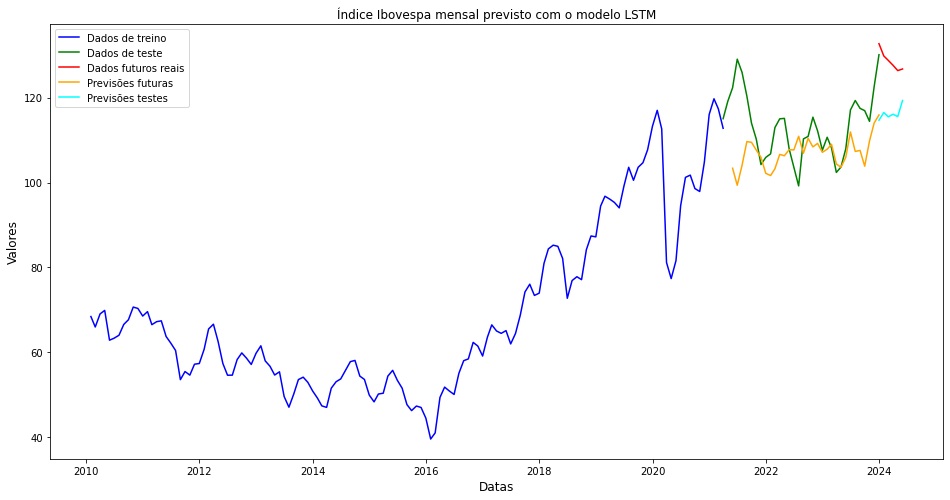

In [95]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
plt.plot(treino_mensal.index, treino_mensal['valor'],color='blue', label='Dados de treino')
plt.plot(teste_mensal.index, teste_mensal['valor'],color='green', label='Dados de teste')
plt.plot(previsao_mensal.index, previsao_mensal['valor'],color='red', label='Dados futuros reais')


# Linha das previsões
plt.plot(teste_mensal[2:].index,best_prediction2,label='Previsões futuras',color = 'orange')
plt.plot(previsao_mensal.index,prediction_val,label='Previsões testes',color = 'cyan')


plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa mensal previsto com o modelo LSTM')

plt.legend()
plt.show()

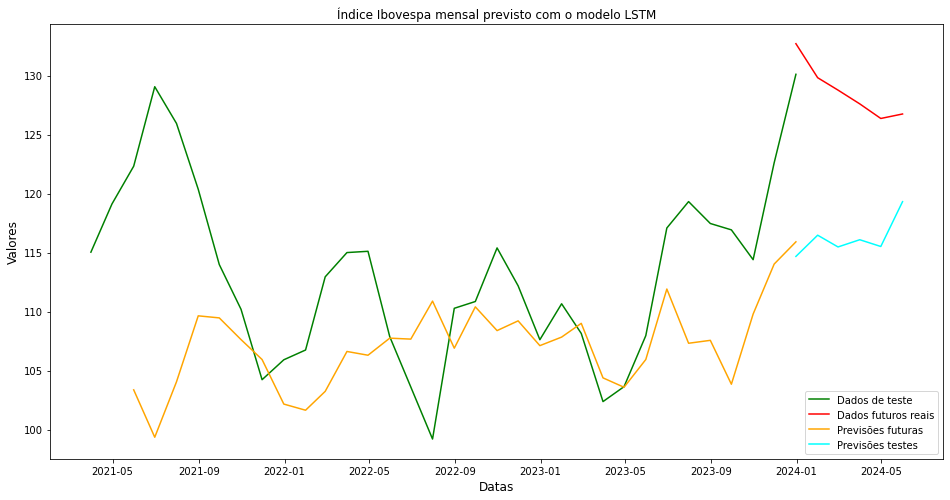

In [96]:
# Plotando os resultados
plt.figure(figsize=(16, 8))

# Linha da série temporal
#plt.plot(treino_mensal.index, treino_mensal['valor'],color='blue', label='Dados de treino')
plt.plot(teste_mensal.index, teste_mensal['valor'],color='green', label='Dados de teste')
plt.plot(previsao_mensal.index, previsao_mensal['valor'],color='red', label='Dados futuros reais')


# Linha das previsões
plt.plot(teste_mensal[2:].index,best_prediction2,label='Previsões futuras',color = 'orange')
plt.plot(previsao_mensal.index,prediction_val,label='Previsões testes',color = 'cyan')


plt.ylabel('Valores', fontsize=12)
plt.xlabel('Datas', fontsize=12)
plt.title('Índice Ibovespa mensal previsto com o modelo LSTM')

plt.legend()
plt.show()